In [1]:
import os
import tqdm
import copy
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from alignment_helper_fns import *
from gop_helper_fns import *
from mfa_evaluation_utils import *
from g2p_en import G2p
g2p = G2p()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/prad/anaconda3/envs/a2/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [2]:
satdf = pd.read_csv('./results_sat/results.csv').set_index('Unnamed: 0')
xsatdf = pd.read_csv('./results_sat_xvector/results_xvector_proj.csv')
xsatdf = xsatdf.rename(columns={'Unnamed: 0': 'Speaker'})


results_dir_frame = './results_frame_10epochs'
results_dir_ivec = './results_sat'
# results_dir_xvec = './results_sat_xvector'
results_dir_xvec = './phone_matched_xvec_proj_textgrids'

In [32]:
%%capture
speaker_tgs = {}

nmanual = 0
nframe = 0
nivec = 0
nxvec = 0
for speakerid in list(satdf.index):
    tg_dct = {}
    
    tg_dct['Manual'] = get_all_textgrids_in_directory(os.path.join('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/', speakerid))
    tg_dct['Frame'] = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid))
    tg_dct['MFA'] = get_all_textgrids_in_directory(os.path.join('./results_mfa_adapted', speakerid))
    tg_dct['xvector'] = get_all_textgrids_in_directory(os.path.join('./phone_matched_xvec_proj_textgrids', speakerid))
    # tg_dct['xvector'] = get_all_textgrids_in_directory(os.path.join('./results_xvector_reevaluated', speakerid))
    tg_dct['ivector'] = get_all_textgrids_in_directory(os.path.join('./results_mfa_adapted', speakerid))

    nmanual += len(tg_dct['Manual'])
    nframe += len(tg_dct['Frame'])
    nivec += len(tg_dct['ivector'])
    nxvec += len(tg_dct['xvector'])
    
    speaker_tgs[speakerid] = tg_dct
    


In [33]:
EXCLUDE_FILES = ['0505_M_EKs4T10', '0411_M_LMwT32']

allmanual_tgs = [pth for pth in get_all_textgrids_in_directory('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/') if '.TextGrid' in pth]
allmanual_tgs = [tg for tg in allmanual_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

ivector_tgs =[pth for pth in get_all_textgrids_in_directory('./results_sat') if '.TextGrid' in pth]
ivector_tgs = [tg for tg in ivector_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]


xvector_tgs =[pth for pth in get_all_textgrids_in_directory('./phone_matched_xvec_proj_textgrids') if '.TextGrid' in pth]
# xvector_tgs =[pth for pth in get_all_textgrids_in_directory('./results_xvector_reevaluated') if '.TextGrid' in pth]
xvector_tgs = [tg for tg in xvector_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

mfa_tgs = [pth for pth in get_all_textgrids_in_directory('./results_mfa_adapted') if '.TextGrid' in pth]
mfa_tgs = [tg for tg in mfa_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

print('Num Mismatched:\t', sum([f1.split('/')[-1].split('.')[0]!=f2.split('/')[-1].split('.')[0] for f1, f2 in zip(allmanual_tgs, xvector_tgs)]))

Extracting all textgrids in directory:	 /home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/


43it [00:00, 6379.06it/s]


Extracting all textgrids in directory:	 ./results_sat


43it [00:00, 6490.39it/s]


Extracting all textgrids in directory:	 ./phone_matched_xvec_proj_textgrids


43it [00:00, 7137.97it/s]


Extracting all textgrids in directory:	 ./results_mfa_adapted


43it [00:00, 6881.15it/s]

Num Mismatched:	 0


In [5]:
print(len(allmanual_tgs))
print(len(ivector_tgs))
print(len(xvector_tgs))
print(len(mfa_tgs))

3762
3762
3762
3762


In [6]:
'''
1. loop through the textgrids and find the cases where the phoneme sequence from g2p does not match the phoneme sequence in hand alignment
2. loop through the textgrids and find the cases where the phoneme sequence from g2p does not match the predicted
'''
def get_audiopath_from_tgfile(tgfilepath, datapath = '/home/prad/datasets/ChildSpeechDataset/child_speech_16_khz'):    
    speaker_id = tgfilepath.split('/')[-2]
    wavfname = tgfilepath.split('/')[-1].split('.')[-2] + '.wav'
    wavfpath = os.path.join(datapath, speaker_id, wavfname)
    return wavfpath

def remove_sil_from_phonelist(phonelist):
    res = list(filter(('[SIL]').__ne__, phonelist))
    res = list(filter(('sil').__ne__, phonelist))

    return res

def get_transcript_from_tgfile(tgfilepath, datapath = '/home/prad/datasets/ChildSpeechDataset/child_speech_16_khz'):
    try:
        speaker_id = tgfilepath.split('/')[-2]
    except:
        print(tgfilepath)
    scriptfname = tgfilepath.split('/')[-1].split('.')[-2] + '.lab'
    scriptfpath = os.path.join(datapath,  speaker_id, scriptfname)
    f = open(scriptfpath)
    transcript = f.read().replace('\n', ' ')
    f.close()
    return transcript



In [34]:
def phone_in_tg(tg, phone, count=False):
    tgphones = np.unique(tg.iloc[:, 2].values).ravel()
    return phone in tgphones

def get_phonecount(tg, phone, key=None, loc=None):
    return sum(tg.iloc[:, 2].values==phone)

def get_phone_startend(tg, phone, key=None, loc=None):
    if key is not None:
        loc = np.argwhere(tg.columns==key).ravel()[0]
    
    tgphonedf = tg[tg.iloc[:, 2]==phone]
    starttimes = tgphonedf.iloc[:, 0].values
    endtimes = tgphonedf.iloc[:, 1].values
    return starttimes, endtimes

def get_onoff_error(tg_gt, tg_estim, phone, verbose=False):
    gtstart, gtend = get_phone_startend(tg_gt, phone, loc=2)
    start, end = get_phone_startend(tg_estim, phone, loc=2)
    if len(gtstart) != len(start):
        if verbose:
            print('Exception for phone [%s]: Ground truth has %d %ss, estimate has %d %ss' % (phone, len(gtstart), phone, len(start), phone))
            print(tg)
            print(tg_gt)
        duration_gt = np.array([np.nan])
        duration_est = np.array([np.nan])
        
        duration_err = np.array([np.nan])
        onset_err = np.array([np.nan])
        offset_err = np.array([np.nan])
        error_indicator = True
    else:
        duration_gt = gtend - gtstart
        duration_est = end - start
        duration_err = duration_gt - duration_est
        onset_err = gtstart - start    
        offset_err = gtend - end
                
    # if len(duration_est) != len(offset_err):
    #         print('-----------------------------------------------------------------')
    #         print('Error Mismatch!')
    #         print('Gt start', gtstart, '\tLen', len(gtstart))
    #         print('Est Start', start, '\tLen', len(start))
    #         print('Durations Est:\t', duration_est, '\tLen', len(duration_est))
    #         print('OnsetErr', onset_err, '\tLen', len(onset_err))
    #         print('OffsetErr', offset_err, '\tLen', len(offset_err))
    #         # print(len(duration_est), duration_est)
    #         # print(len(onset_err), )
    #         # print(tg)
    #         # print(tg_gt)

    return onset_err, offset_err, duration_err, duration_gt, duration_est

def get_phone_durations(tg, phone, key=None, loc=None):
    if key is not None:
        loc = np.argwhere(tg.columns==key).ravel()[0]
        
    start, end = get_phone_startend(tg, phone, loc=2)
    
    return end - start
    
    
def tg_error(tg_gt, tg_estim, phone, loc=2, verbose=False):
    stats = {}
    
    onset_err, offset_err, duration_error, duration_gt, duration_est = get_onoff_error(tg_gt, tg_estim, phone, verbose=verbose)
    
    stats['durations_gt'] = duration_gt
    stats['durations_est'] = duration_est
    stats['onset_error'] = onset_err
    stats['offset_error'] = offset_err
    stats['duration_error'] = duration_error
    
    return stats

def get_gt_tg(manual_tgpaths, target_tgpath, phone_key='ha phones'):
    fname = target_tgpath.split('/')[-1]
    idx = np.argwhere([fname in mtg for mtg in manual_tgpaths]).ravel()[0]
    return textgridpath_to_phonedf(manual_tgpaths[idx], phone_key=phone_key, remove_numbers=True)

In [8]:
def is_start_phone(phn, phonelist):
    space_locs = np.argwhere(phonelist==' ').ravel()
    start_idxs = np.concatenate(([0], space_locs+1))    
    phn_idx = np.argwhere(phonelist==phn)
    return any([_idx in start_idxs for _idx in phn_idx])

def is_end_phone(phn, phonelist):
    space_locs = np.argwhere(phonelist==' ').ravel()
    end_idxs = np.concatenate((space_locs-1, [len(phonelist)]))
    phn_idx = np.argwhere(phonelist==phn)
    return any([_idx in start_idxs for _idx in phn_idx])


def collapse_repeated_phones(input_df, phonekey='phone'):
    # keepdata = []
    inp_df = copy.deepcopy(input_df)
    ii=0
    while ii<len(inp_df)-1:
        if inp_df.at[ii, phonekey]==inp_df.at[ii+1, phonekey]:
            newend = inp_df.at[ii+1, 'end']
            inp_df.at[ii, 'end'] = newend
            inp_df = inp_df.drop(ii+1, axis=0).reset_index(drop=True)
        else:
            ii+=1
    return inp_df

# def process_silences(inp_df, transcript, silphone='sil'):
#     phonelist = g2p(transcript)
#     tgdf = copy.deepcopy(inp_df)
#     ''' flag silences in the middle of a word with nan'''
#     for ii in range(len(tgdf)):
#         if ii<len(tgdf)-1 and ii>0:
#             # print(tgdf[phonekey][ii])
#             if tgdf['phone'][ii]=='sil':
#                 prevphone = tgdf['phone'].iloc[ii-1]
#                 nextphone = tgdf['phone'].iloc[ii+1]

#                 if prevphone==nextphone and not(is_end_phone(prevphone, phonelist) and is_start_phone(nextphone, phonelist)):
#                     tgdf.at[ii, 'phone'] = np.nan
                    
#     ''' remove the silences'''
#     # tgdf = tgdf[~pd.isna(tgdf[phonekey])].reset_index(drop=True).drop(columns=['index'])
#     tgdf = tgdf[~pd.isna(tgdf['phone'])].reset_index(drop=True)
#     ''' collapse the repeated phonemes '''
#     return collapse_repeated_phones(tgdf, phonekey='phone')


def get_phone_by_word(transcript):
    words = transcript.split(' ')
    phonelist = [[re.sub(r'[0-9]+', '', _w) for _w in g2p(_word)] for _word in words]
    return phonelist
    
# def process_silence(tgpath, transcript, phone_key='phones'):
#     phonelist = get_phone_by_word(transcript)
#     textgridpath_to_phonedf(tgpath, phone_key=phone_key)
    
# for ii in range(len(_df)):
#     if ii<len(_df)-1 and ii>0:
#         print(_df['phone'][ii])
#         if _df['phone'][ii]=='sil':
#             prevphone = _df['phone'].iloc[ii-1]
#             nextphone = _df['phone'].iloc[ii+1]
            
#             if prevphone==nextphone and not(is_end(prevphone, phonelist) and is_start_phone(nextphone, phonelist)):
#                 _df.at[ii, 'phone'] = np.nan

In [ ]:
def contains_same_phones(phone_list1, phone_list2):
    return np.logical_and.reduce(np.unique(phone_list1)==np.unique(phone_list2))
    
phonecounts = {}
phonecounts_man = {}

phonewise_te = {}

phonewise_gops_man = {}
phonewise_gops_xvec = {}

phonedurations_man = {}
phonedurations = {}

for phone in ENGLISH_PHONEME_LIST:
    phonewise_gops_man[phone] = []
    phonewise_gops_xvec[phone] = []
    
    phonewise_te[phone] = []
    
    phonecounts_man[phone] = 0
    phonecounts[phone] = 0
    
    phonedurations_man[phone] = []
    phonedurations[phone] = []

def get_df_row_as_tuples(inpdf):
    [tuple(row[1].values) for row in inpdf.iterrows()]
def provide_display(transcript, filepath, tgpath, tg1df, tg2df, tg3df=None):
    p1 = np.array(remove_sil_from_phonelist(tg1df.phone.values))
    p2 = np.array(remove_sil_from_phonelist(tg2df.phone.values))
    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------')
    print(tgpath)
    print(transcript)
    print('------------------------------------------------------------------------------------------------')
    print('File:\t', filepath)
    # print('------', ii)
    print('Transcript:\t', transcript)
    _g2p = g2p(transcript)

    if ' ' in _g2p:
        _g2p.remove(' ')

    print('g2p:\t\t\t', _g2p)
    print('------')
    print('Predicted Phone Sequence:\t', p2)
    print('ManualPhones:\t\t', p1)

    print('------ Manual Textgrid')
    print(tg1df)
    print('------ Aligned Textgrid')
    print(tg2df)
    if tg3df is not None:
        print('---------- Fixed Aligned TG')
        print(tg3df)
ii=0
nmiss_tot = 0
g2p_mismatch = 0
len_mismatch = 0
shortcount = 0

allphones = []
DISPLAY_MISMATCHES = False
DISPLAY_SHORTPHONES = False
sameseq_diff_len = 0
phone_error_rates = []
alignment_scores = []

nerr = 0
for f1, f2 in tqdm.tqdm(zip(allmanual_tgs, xvector_tgs)):
    mismatch = False
    wavfpath = get_audiopath_from_tgfile(f1)
    transcript = get_transcript_from_tgfile(f1)
    tg1 = textgridpath_to_phonedf(f1, phone_key='ha phones', remove_numbers=True)
    tg2 = textgridpath_to_phonedf(f2, phone_key='phones', remove_numbers=True)
    # tg2_orig = copy.deepcopy(tg2)
    # tg2 = process_silences(tg2, transcript)
    
    tg1rows = [tuple(row[1]) for row in tg1.iterrows()]
    tg2rows = [tuple(row[1]) for row in tg2.iterrows()]
    
    # outputsmanual = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg1)
    # outputsxvec = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg2)
    tg1['duration'] = tg1['end'] - tg1['start']
    tg2['duration'] = tg2['end'] - tg2['start']
    p1 = np.array(remove_sil_from_phonelist(tg1.phone.values))
    p2 = np.array(remove_sil_from_phonelist(tg2.phone.values))
    
    durations = tg2['end'] - tg2['start']

    show = False
    for jj in range(tg1.shape[0]):
        phone = tg1.iloc[jj]['phone']
        if not phone=='[SIL]' and phone in ENGLISH_PHONEME_LIST:
            phonedurations_man[phone].append((tg1.iloc[jj, 1] - tg1.iloc[jj, 0])*1000)
            phonecounts_man[phone] += 1
        
    for jj in range(tg2.shape[0]):
        phone = tg2.iloc[jj]['phone']
        if not phone=='[SIL]' and phone in ENGLISH_PHONEME_LIST:
            phonedurations[phone].append((tg2.iloc[jj, 1] - tg2.iloc[jj, 0])*1000)
            phonecounts[phone] += 1
            
    _phone='IY'
    if _phone in p2:
        pdur = tg2['duration'][tg2['phone']==_phone].values
        if any(pdur<.1):
            if DISPLAY_SHORTPHONES:
                provide_display(transcript, wavfpath, f2, tg1, tg2)
            shortcount +=  1
            
    # if any(durations<.04):
        # provide_display(transcript, wavfpath, f2, tg1, tg2)
        # shortcount +=  1
    rslts = calc_alignment_cost(get_df_rows_as_tuples(tg1), get_df_rows_as_tuples(tg2), return_all_metrics=True)
    alignment_scores.append(rslts['AlignmentScore'])
    phone_error_rates.append(rslts['PhoneErrorRate'])
    if len(p1)!=len(p2):
        len_mismatch += 1
        provide_display(transcript, wavfpath, f2, tg1, tg2)
        mismatch=True
    elif not all(p1==p2):
        # g2p_mismatch += 1
        mismatch=True
        
    else:
#         outputsmanual = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg1)[0]
#         outputsxvec = calculate_GOP_e2e(wavfpath, transcript=transcript, textgrid_alignment=tg2)[0]
        
#         for phone in p1:
#             manual_gop = outputsmanual[outputsmanual['Phone']==phone]['GOP'].iloc[0]
#             xvec_gop = outputsxvec[outputsxvec['Phone']==phone]['GOP'].iloc[0]
            

            
#             phonewise_gops_man[phone].append(manual_gop)
#             phonewise_gops_xvec[phone].append(xvec_gop)
            
        for kk in range(tg1.shape[0]):
            phone = tg1.loc[kk, 'phone']
            if phone=='sil' or phone=='[UNK]' or phone=='[SIL]':
                continue
            else:
                onset_gt = tg1.loc[kk, 'start']
                offset_gt = tg1.loc[kk, 'end']

                onset_xvec = tg2.loc[kk, 'start']
                offset_xvec = tg2.loc[kk, 'end']

                te = (np.abs(onset_gt - onset_xvec) - np.abs(offset_gt - offset_xvec))/2
                phonewise_te[phone].append(te)
        pass
            
    allphones.extend(p1)
    
    if mismatch==True:
        nmiss_tot += 1

        # print(p1)
        # print(p2)
        if len(p1) != len(p2):
            if len(np.unique(p1))==len(np.unique(p2)):
                # if contains_same_phones(p1, p2):
                sameseq_diff_len+=1
                if DISPLAY_MISMATCHES:
                    provide_display(transcript, wavfpath, f2, tg1, tg2)
        else:
            if len(np.unique(p1))==len(np.unique(p2)):
                g2p_mismatch += 1
    # ii+=1
    # if ii>1000:
    #     break
print('Num Total Mismatch:\t', nmiss_tot)
print('Num Length Mismatch:\t', len_mismatch)
print('Num G2p Mismatch:\t', g2p_mismatch)
print('Shortcount', shortcount)

In [9]:
print('Num Total Mismatch:\t', nmiss_tot, 100*nmiss_tot/len(allmanual_tgs))
print('Num Length Mismatch:\t', len_mismatch,  100*len_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', g2p_mismatch, 100*g2p_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', shortcount, 100*shortcount/len(allmanual_tgs))
print('Average Alignment Score:\t', np.mean(alignment_scores))
print('Phone Error Rate:\t', np.mean(phone_error_rates))

Num Total Mismatch:	 733 19.484316852737905
Num Length Mismatch:	 365 9.702286018075492
Num G2p Mismatch:	 252 6.698564593301436
Num G2p Mismatch:	 147 3.9074960127591707
Average Alignment Score:	 -0.4474160210805418
Phone Error Rate:	 0.2196349773931927


In [22]:
print('Num Total Mismatch:\t', nmiss_tot, 100*nmiss_tot/len(allmanual_tgs))
print('Num Length Mismatch:\t', len_mismatch,  100*len_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', g2p_mismatch, 100*g2p_mismatch/len(allmanual_tgs))
print('Num with short:\t', shortcount, 100*shortcount/len(allmanual_tgs))
print('Average Alignment Score:\t', np.mean(alignment_scores))
print('Phone Error Rate:\t', np.mean(phone_error_rates))

Num Total Mismatch:	 264 7.017543859649122
Num Length Mismatch:	 257 6.831472620946305
Num G2p Mismatch:	 6 0.1594896331738437
Num with short:	 200 5.31632110579479
Average Alignment Score:	 -0.4483790788119282
Phone Error Rate:	 0.18463419742296266


In [28]:
print('Num Total Mismatch:\t', nmiss_tot, 100*nmiss_tot/len(allmanual_tgs))
print('Num Length Mismatch:\t', len_mismatch,  100*len_mismatch/len(allmanual_tgs))
print('Num G2p Mismatch:\t', g2p_mismatch, 100*g2p_mismatch/len(allmanual_tgs))
print('Num with short:\t', shortcount, 100*shortcount/len(allmanual_tgs))
print('Average Alignment Score:\t', np.mean(alignment_scores))
print('Phone Error Rate:\t', np.mean(phone_error_rates))

Num Total Mismatch:	 782 20.78681552365763
Num Length Mismatch:	 413 10.97820308346624
Num G2p Mismatch:	 242 6.432748538011696
Num with short:	 159 4.226475279106858
Average Alignment Score:	 -0.4990921313903677
Phone Error Rate:	 0.24851351728730056


In [11]:
from Bio import pairwise2
import functools

MATCH_SCORE = 0
MISMATCH_SCORE = 2

def _silence_check(phone):
    return phone in {'sp', '<p:>', '', 'sil', None}

def _compare_labels(ref, test):
    if ref == test:
        return MATCH_SCORE
    ref = ref.lower()
    test = test.lower()
    if ref == test:
        return MATCH_SCORE
    return MISMATCH_SCORE

def _overlap_scoring(firstElement, secondElement):
    # print(firstElement)
    # print(secondElement)
    if firstElement==['-'] or secondElement ==['']:
        begin_diff = abs(firstElement[0] - secondElement[0])
        end_diff = abs(firstElement[1] - secondElement[1])
        label_diff = _compare_labels(firstElement[2], secondElement[2])
        return -1 * (begin_diff + end_diff + label_diff)
    else:
        return -2


score_func = functools.partial(_overlap_scoring)

In [12]:
def calc_alignment_cost(alignment):
    overlap_count = 0
    overlap_sum = 0
    num_insertions = 0
    num_deletions = 0
    for a in alignments:
        for i, sa in enumerate(a.seqA):
            sb = a.seqB[i]
            print(sb, sa)
            if sa == '-':
                if not silence_check(sb[2]):
                    num_insertions += 1
                else:
                    continue
            elif sb == '-':
                if not _silence_check(sb[2]):
                    num_deletions += 1
                else:
                    continue
            else:
                overlap_sum += abs(sa[0] - sb[0]) + abs(sa[1] - sb[1])
                overlap_count += 1
        return overlap_sum/overlap_count, num_insertions, num_deletions


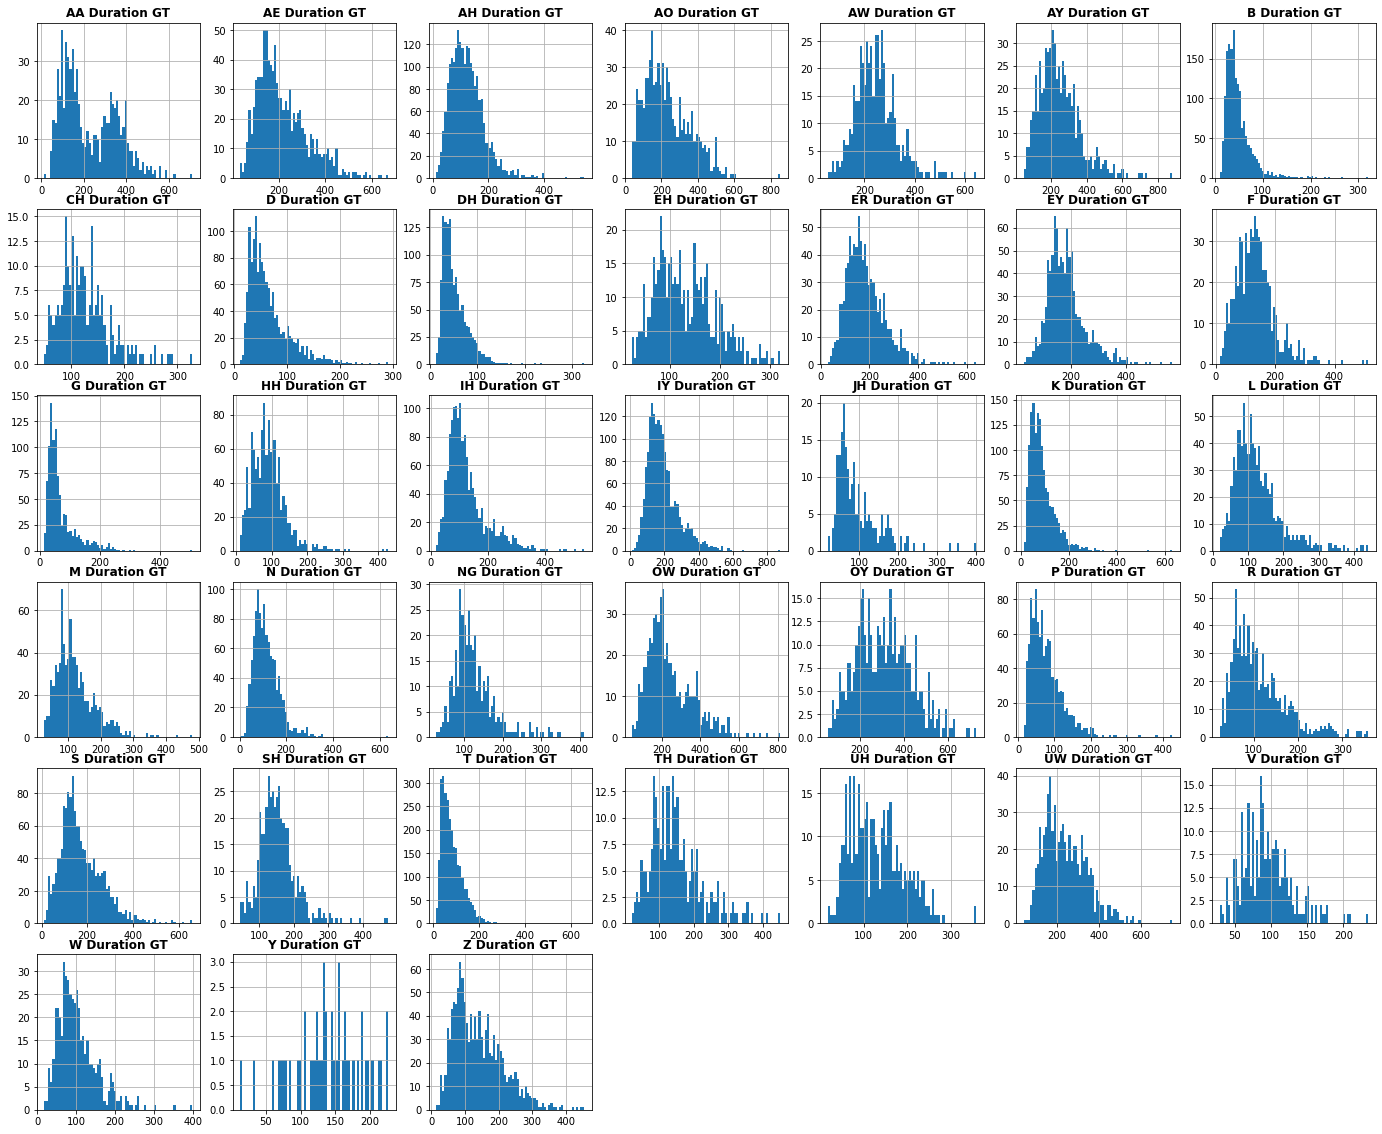

In [17]:
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    plt.subplot(6, 7, ii+1)
    plt.hist(phonedurations_man[phone], bins=70)    
    # plt.xlim([0, 40])
    plt.grid()
    plt.title('%s Duration GT' % phone, fontweight='bold')

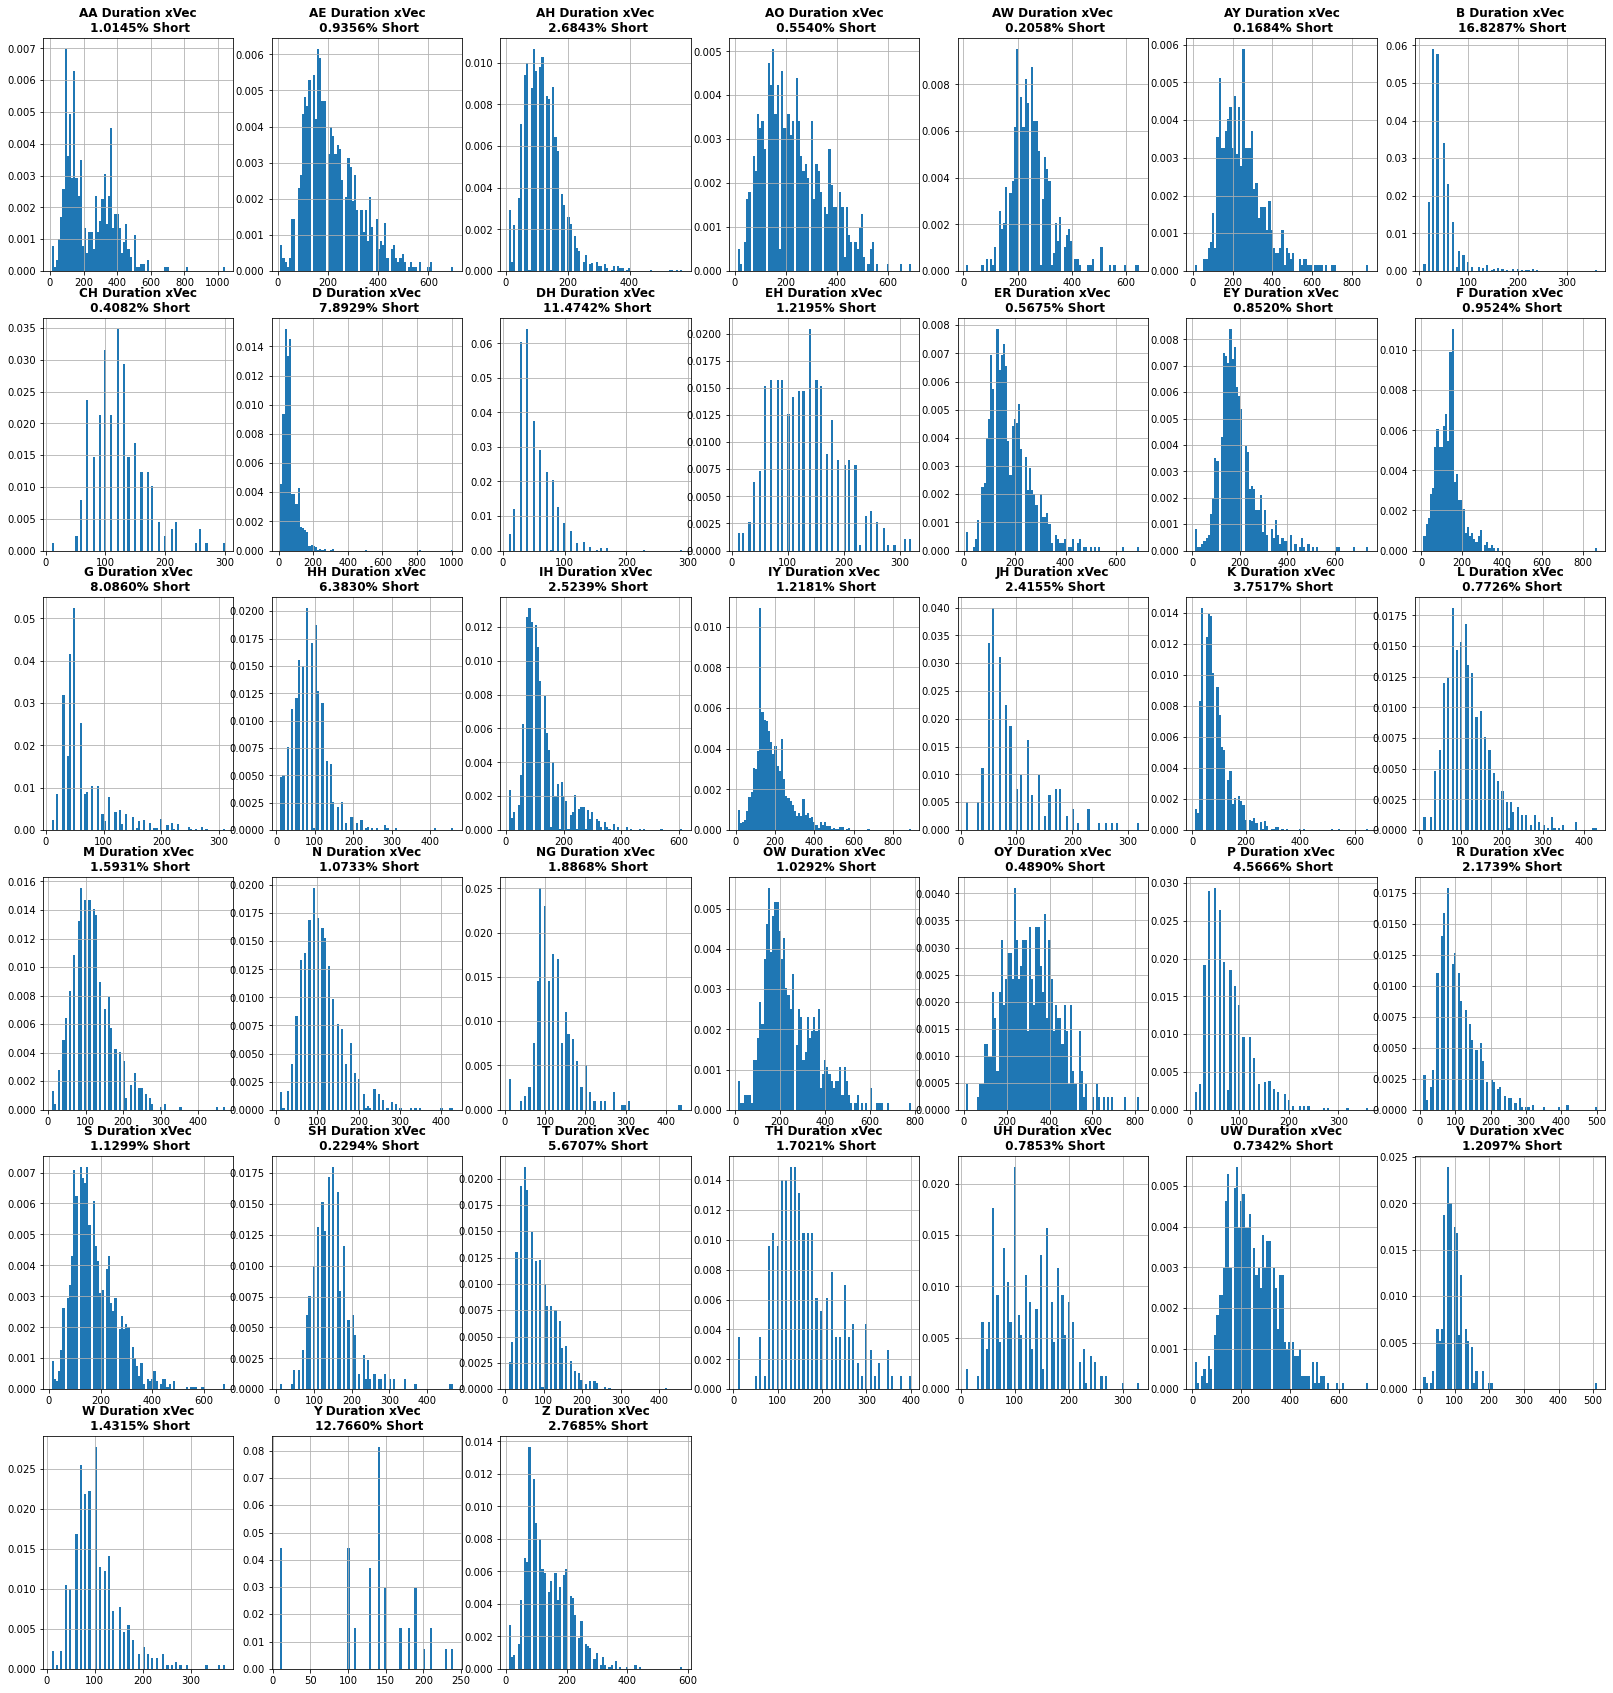

In [37]:
plt.figure(figsize=(28, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80, density=True)
    # plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

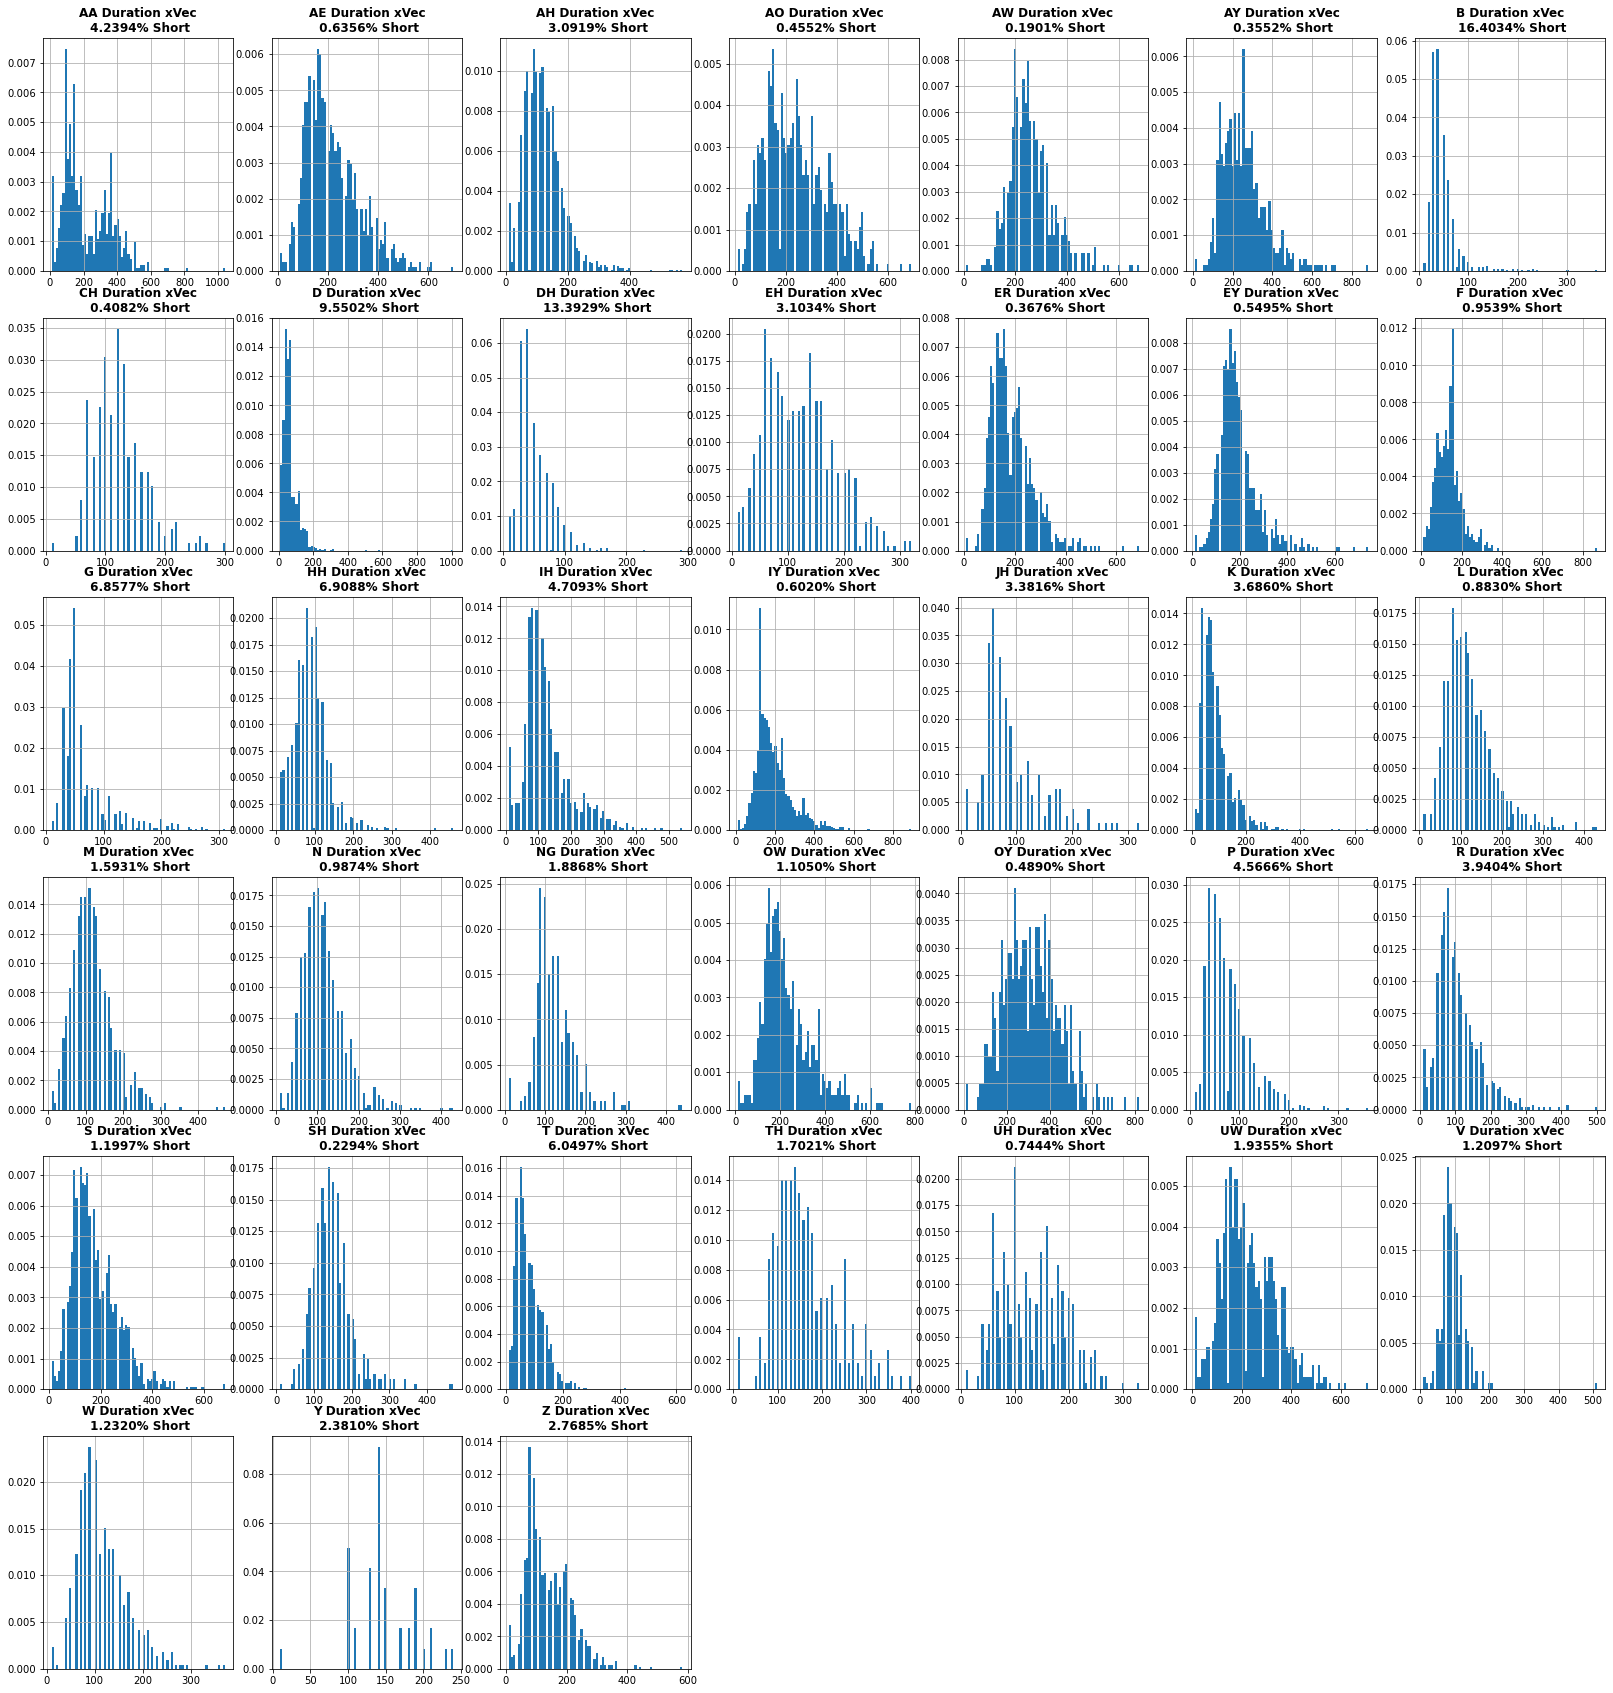

In [31]:
plt.figure(figsize=(28, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80, density=True)
    # plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [ ]:
plt.figure(figsize=(36, 40))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(8, 6, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80)
    # plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.savefig('./phoneduration_lists.png', bbox_inches='tight')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [ ]:
plt.figure(figsize=(30, 28))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(phonedurations[phone], bins=80)
    plt.xlim([0, 50])
    plt.grid()
    numshort = sum(np.array(phonedurations[phone])<30)
    plt.title(f"{phone} Duration xVec\n{numshort:d} Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [13]:
pctile_1st = {}

for phone in ENGLISH_PHONEME_LIST:
    pctile_1st[phone] = np.percentile(phonedurations_man[phone], 0.2)

In [195]:
# 'phone': [phone] * len(durations_gt['frame']), 'duration_gt': durations_gt['frame'], 'duration_est':durations_est['frame'], 
# 'onset_err_frame': onset_err['frame'], 'offset_err_frame': offset_err['frame']
# print(len(durations_gt['frame']))
print(len(durations_est['frame']))
print(len(onset_err['frame']))
print(len(offset_err['frame']))
    

17
17
17


In [ ]:
''' 
TODO:



Create an evaluator class
inputs: 
- manual tg list
- dict of a list of tgs {"aligner_method_name1": tg_list, "aligner_method_name2": tg_list2, ...}



'''


In [38]:
def evaluate_tg_results(method, phone, tglist, tgs_manual, durations_est, onset_err, offset_err, phone_key='phones'):
    est_dur = []
    off_err = []
    on_err = []
    nerr = 0
    
    for tgpath in tglist:
        transcript = get_transcript_from_tgfile(tgpath)
        tg = textgridpath_to_phonedf(tgpath, phone_key=phone_key, remove_numbers=True)
        tg = process_silences(tg, transcript)
        tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)
        # print(tgpath)
        # if phone_in_tg(tg, phone):
            # print(tg)
        if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
            metrics = tg_error(tg_gt, tg, phone)
            # print('here')
            # print(metrics)
            # durations_est[method].extend(list(metrics['durations_est'] * 1000))
            # onset_err[method].extend(list(metrics['onset_error'] * 1000))
            # offset_err[method].extend(list(metrics['offset_error'] * 1000))

            est_dur.extend(list(metrics['durations_est'] * 1000))
            on_err.extend(list(metrics['onset_error'] * 1000))
            off_err.extend(list(metrics['offset_error'] * 1000))
            
            if any(np.isnan(metrics['onset_error'])):                
                # nfiles_error['frame']+=1
                nerr += 1
    return est_dur, on_err, off_err, nerr


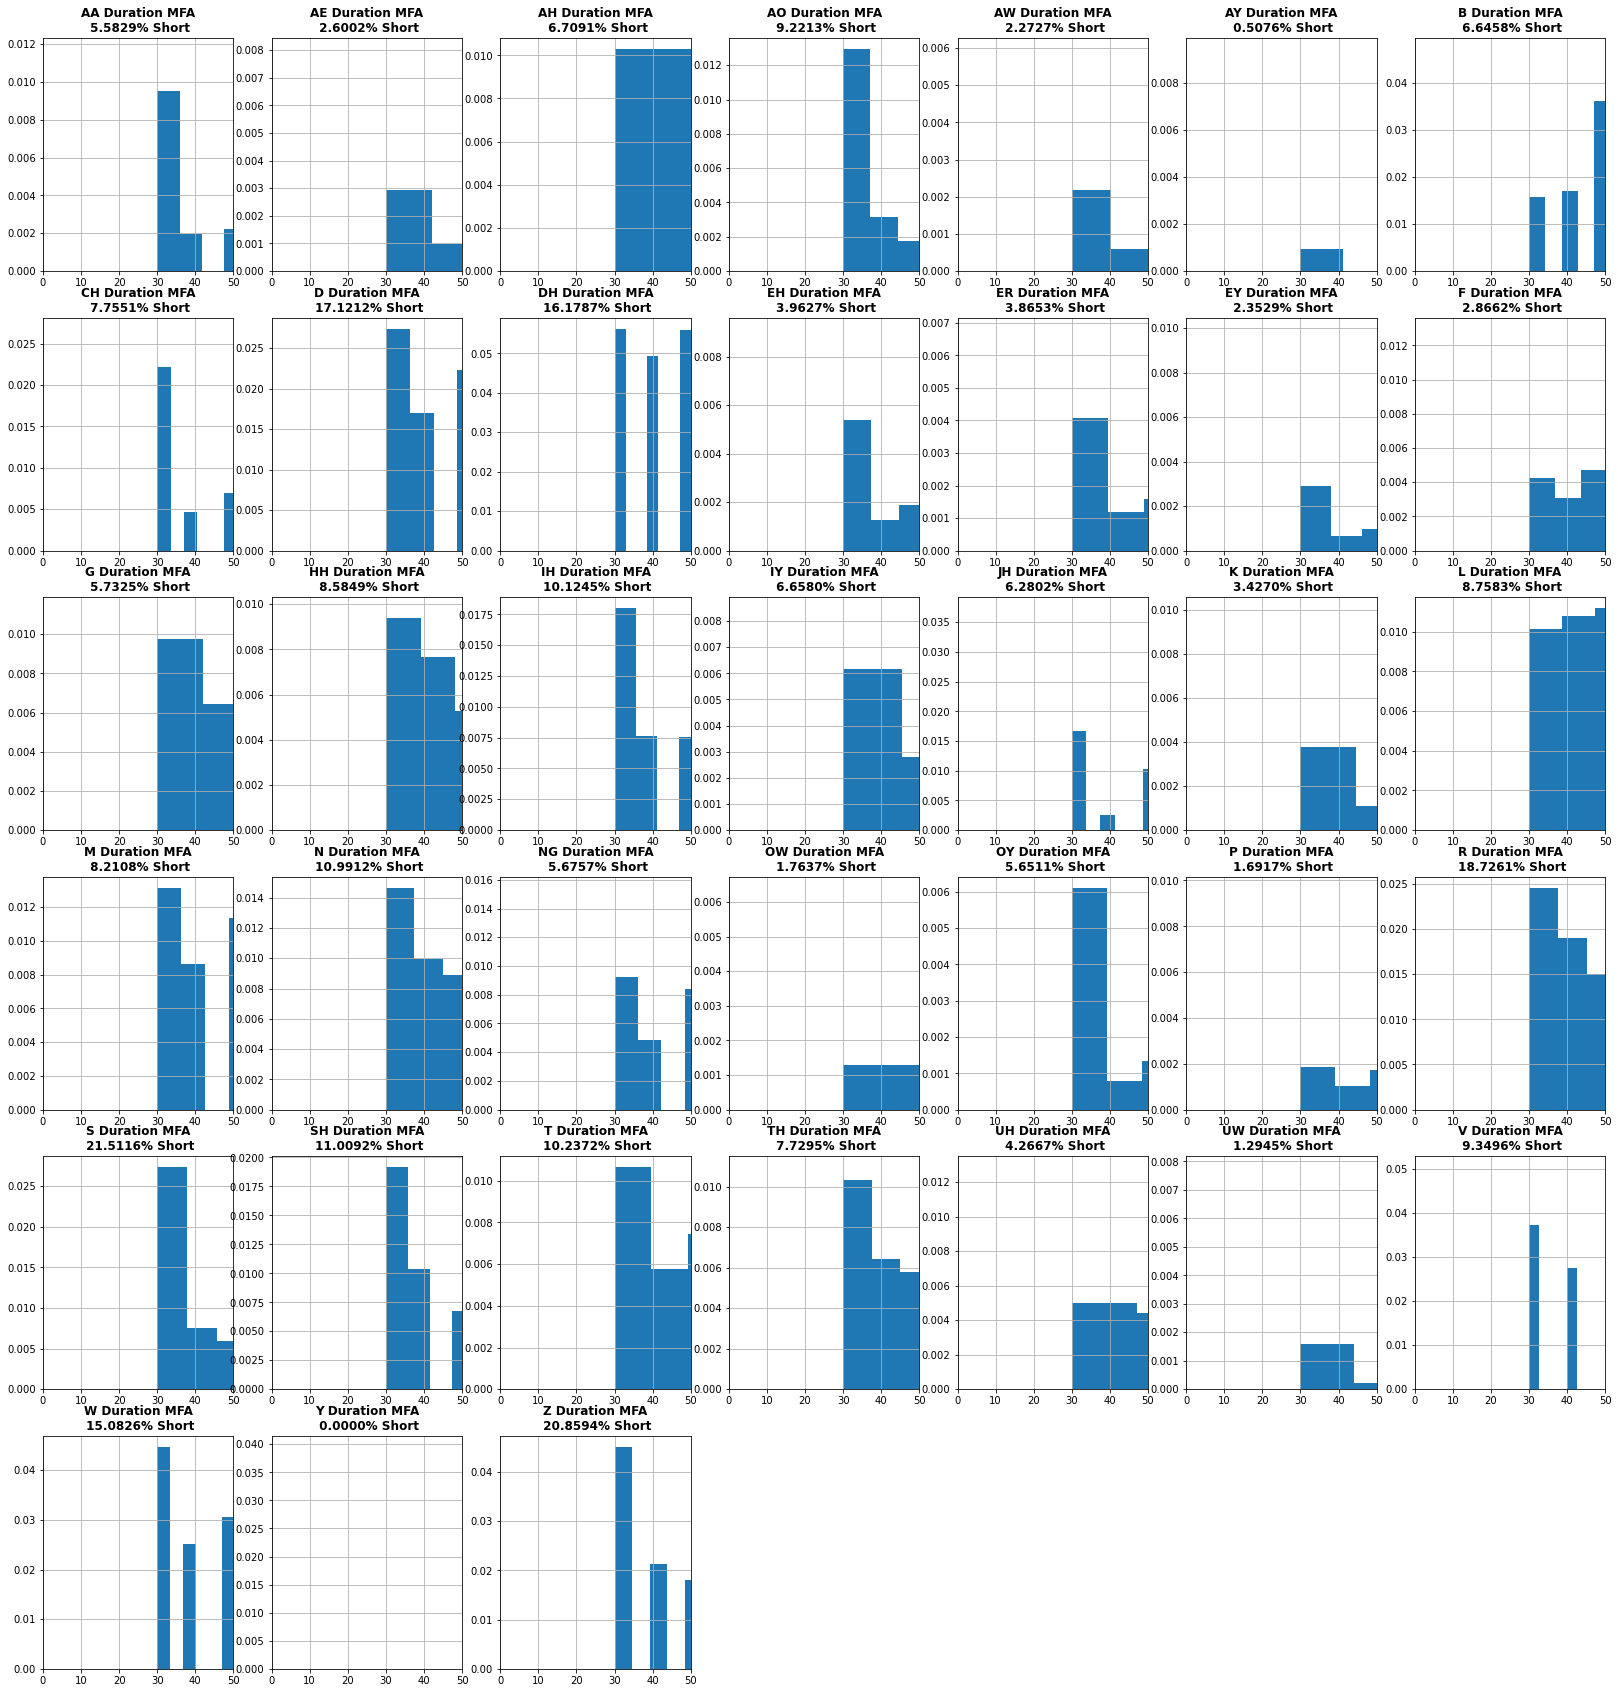

In [301]:
plt.figure(figsize=(28, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    durations = phone_dfs[phone]['mfa']['duration_est_mfa'].values
    durations = durations[~np.isnan(durations)]
    # _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    # plt.hist(phonedurations[phone], bins=70)
    plt.hist(durations, bins=80, density=True)
    plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(durations<=35))/sum(~np.isnan(durations))
    plt.title(f"{phone} Duration MFA\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [39]:
if not (os.path.exists('./outputs/gt_dfs.pkl') and os.path.exists('./outputs/phone_accuracy_dfs_matched.pkl')):
    phone_durations = {}
    phone_onset_err = {}
    phone_offset_err = {}
    phone_ids = {}
    age = {}
    nexclude_per = {}

    phone_dfs = {'frame': {}, 'ivector': {}, 'xvector': {}}
    finish = False

    gt_dfs = {}
    for phone in tqdm.tqdm(ENGLISH_PHONEME_LIST):
        print('Calculating error for phone: \t ', phone)
        durations_gt = {}
        durations_est = {}
        onset_err = {}
        offset_err = {}

        nfiles_error = {}

        phone_dfs[phone] = {}

        phone_ids['frame'] = []
        phone_ids['ivector'] = []
        phone_ids['xvector'] = []
        phone_ids['mfa'] = []
        
        durations_est['frame'] = []
        durations_est['ivector'] = []
        durations_est['xvector'] = []
        durations_est['mfa'] = []
        

        durations_gt['frame'] = []
        durations_gt['ivector'] = []
        durations_gt['xvector'] = []
        durations_gt['mfa'] = []
        
        onset_err['frame'] = []
        onset_err['ivector'] = []
        onset_err['xvector'] = []
        onset_err['mfa'] = []
        
        offset_err['frame'] = []    
        offset_err['ivector'] = []
        offset_err['xvector'] = []
        offset_err['mfa'] = []
        
        nfiles_error['frame'] = 0
        nfiles_error['ivector'] = 0
        nfiles_error['xvector'] = 0 
        nfiles_error['mfa'] = 0

        start_gt = []
        end_gt = []
        durations_gt = []
        speaker_id = []
        #iterate over speakers
        for speakerid in list(satdf.index):
            # print('Analyzing speaker:    ', speakerid)
            # print(speakerid)
            tgs_manual = get_all_textgrids_in_directory(os.path.join('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/', speakerid), verbose=False)
            tgs_frame = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid), verbose=False)
            tgs_xv = get_all_textgrids_in_directory(os.path.join('./phone_matched_xvec_proj_textgrids', speakerid), verbose=False)
            tgs_iv = get_all_textgrids_in_directory(os.path.join('./results_sat', speakerid), verbose=False)
            tgs_mfa = get_all_textgrids_in_directory(os.path.join('./results_mfa_adapted', speakerid), verbose=False)

            for manual_tgpath in tgs_manual:
                manual_tg = textgridpath_to_phonedf(manual_tgpath, phone_key='ha phones', remove_numbers=True)
                gtstart, gtend = get_phone_startend(manual_tg, phone, loc=2)
                durations_gt.extend(list((gtend - gtstart) * 1000))
                speaker_id.extend([speakerid] * len(gtstart))
                start_gt.extend(list(gtstart * 1000))
                end_gt.extend(list(gtend * 1000))
                
            
            
            est_dur, on_err, off_err, nerr = evaluate_tg_results('frame', phone, tgs_frame, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['frame'].extend(on_err)
            offset_err['frame'].extend(off_err)
            durations_est['frame'].extend(est_dur)
            nfiles_error['frame'] += nerr
            est_dur, on_err, off_err, nerr = evaluate_tg_results('ivector', phone, tgs_iv, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['ivector'].extend(on_err)
            offset_err['ivector'].extend(off_err)
            durations_est['ivector'].extend(est_dur)
            nfiles_error['ivector'] += nerr
            est_dur, on_err, off_err, nerr = evaluate_tg_results('xvector', phone, tgs_xv, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['xvector'].extend(on_err)
            offset_err['xvector'].extend(off_err)
            durations_est['xvector'].extend(est_dur)
            nfiles_error['xvector'] += nerr
            est_dur, on_err, off_err, nerr = evaluate_tg_results('mfa', phone, tgs_mfa, tgs_manual, durations_est, onset_err, offset_err)
            onset_err['mfa'].extend(on_err)
            offset_err['mfa'].extend(off_err)
            durations_est['mfa'].extend(est_dur)
            nfiles_error['mfa'] += nerr

#             for tgpath in tgs_frame:
#                 transcript = get_transcript_from_tgfile(tgpath)
#                 tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
#                 # tg = process_silence(tg, transcript)
                
#                 tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)
                
#                 if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
#                     metrics = tg_error(tg_gt, tg, phone)
#                     # print('-----------')
#                     durations_est['frame'].extend(list(metrics['durations_est'] * 1000))
#                     onset_err['frame'].extend(list(metrics['onset_error'] * 1000))
#                     offset_err['frame'].extend(list(metrics['offset_error'] * 1000))

#                     if any(np.isnan(metrics['onset_error'])):                
#                         nfiles_error['frame']+=1
#                         # print(tgpath)


#             for tgpath in tgs_iv:
#                 transcript = get_transcript_from_tgfile(tgpath)
#                 tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
#                 # tg = process_silence(tg, transcript)
                
#                 tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

#                 if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
#                     metrics = tg_error(tg_gt, tg, phone)
#                     # print('-----------')
#                     durations_est['ivector'].extend(list(metrics['durations_est'] * 1000))
#                     onset_err['ivector'].extend(list(metrics['onset_error'] * 1000))
#                     offset_err['ivector'].extend(list(metrics['offset_error'] * 1000))

#                     if any(np.isnan(metrics['onset_error'])):                
#                         nfiles_error['ivector'] += 1

#             finished = False
#             for tgpath in tgs_xv:
#                 transcript = get_transcript_from_tgfile(tgpath)
#                 tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
#                 # tg = process_silence(tg, transcript)
                
#                 tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

#                 if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
#                     metrics = tg_error(tg_gt, tg, phone)
#                     # print('-----------')
#                     durations_est['xvector'].extend(list(metrics['durations_est'] * 1000))
#                     onset_err['xvector'].extend(list(metrics['onset_error'] * 1000))
#                     offset_err['xvector'].extend(list(metrics['offset_error'] * 1000))

#                     if any(np.isnan(metrics['onset_error'])):
#                         nfiles_error['xvector'] += 1
            # if finished:
                # break

        # if finished:
            # break
        df_gt = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt), 'speakerid': speaker_id, 'start_time': start_gt, 'end_time': end_gt})
        # df_frame = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['frame']), 'duration_gt': durations_gt['frame'], 'duration_est':durations_est['frame'], 
        df_frame = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['frame']), 'duration_est':durations_est['frame'], 'onset_err_frame': onset_err['frame'], 'offset_err_frame': offset_err['frame']})

        # df_ivec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['ivector']), 'durations_gt':durations_gt['ivector'], 'duration_est_ivector': durations_est['ivector'], 
        df_ivec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['ivector']), 'duration_est_ivector': durations_est['ivector'], 
                                          'onset_err_ivector': onset_err['ivector'], 'offset_err_ivector': offset_err['ivector']})

        # df_xvec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['xvector']), 'durations_gt':durations_gt['xvector'], 'durations_est_xvector': durations_est['xvector'], 
        df_xvec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['xvector']), 'duration_est_xvector': durations_est['xvector'], 
                                          'onset_err_xvector': onset_err['xvector'], 'offset_err_xvector': offset_err['xvector']})

        df_mfa = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['mfa']), 'duration_est_mfa': durations_est['mfa'], 
                                  'onset_err_mfa': onset_err['mfa'], 'offset_err_mfa': offset_err['mfa']})
            
        gt_dfs[phone] = df_gt
        phone_dfs[phone]['frame'] = df_frame
        phone_dfs[phone]['ivector'] = df_ivec
        phone_dfs[phone]['xvector'] = df_xvec
        phone_dfs[phone]['mfa'] = df_mfa
else:
    gt_dfs = pkl.load(open('./outputs/gt_dfs.pkl', 'rb'))

    phone_dfs = pkl.load(open('./outputs/phone_accuracy_dfs.pkl', 'rb'))

  0%|                                                                                                                                                                                                                                | 0/38 [00:00<?, ?it/s]

Calculating error for phone: 	  AA


  3%|█████▋                                                                                                                                                                                                                  | 1/38 [00:54<33:51, 54.91s/it]

Calculating error for phone: 	  AE


  5%|███████████▎                                                                                                                                                                                                            | 2/38 [01:50<33:04, 55.12s/it]

Calculating error for phone: 	  AH


  8%|█████████████████                                                                                                                                                                                                       | 3/38 [02:44<32:00, 54.88s/it]

Calculating error for phone: 	  AO


 11%|██████████████████████▋                                                                                                                                                                                                 | 4/38 [03:36<30:26, 53.73s/it]

Calculating error for phone: 	  AW


 13%|████████████████████████████▍                                                                                                                                                                                           | 5/38 [04:29<29:22, 53.42s/it]

Calculating error for phone: 	  AY


 16%|██████████████████████████████████                                                                                                                                                                                      | 6/38 [05:24<28:42, 53.82s/it]

Calculating error for phone: 	  B


 18%|███████████████████████████████████████▊                                                                                                                                                                                | 7/38 [06:21<28:20, 54.86s/it]

Calculating error for phone: 	  CH


 21%|█████████████████████████████████████████████▍                                                                                                                                                                          | 8/38 [07:14<27:11, 54.37s/it]

Calculating error for phone: 	  D


 24%|███████████████████████████████████████████████████▏                                                                                                                                                                    | 9/38 [08:10<26:28, 54.77s/it]

Calculating error for phone: 	  DH


 26%|████████████████████████████████████████████████████████▌                                                                                                                                                              | 10/38 [09:05<25:37, 54.91s/it]

Calculating error for phone: 	  EH


 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                        | 11/38 [10:00<24:46, 55.06s/it]

Calculating error for phone: 	  ER


 32%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 12/38 [10:56<23:53, 55.15s/it]

Calculating error for phone: 	  EY


 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 13/38 [11:51<22:56, 55.07s/it]

Calculating error for phone: 	  F


 37%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 14/38 [12:45<21:56, 54.87s/it]

Calculating error for phone: 	  G


 39%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 15/38 [13:40<21:01, 54.84s/it]

Calculating error for phone: 	  HH


 42%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 16/38 [14:35<20:10, 55.04s/it]

Calculating error for phone: 	  IH


 45%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 17/38 [15:30<19:14, 54.99s/it]

Calculating error for phone: 	  IY


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 18/38 [16:28<18:37, 55.89s/it]

Calculating error for phone: 	  JH


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 19/38 [17:20<17:18, 54.65s/it]

Calculating error for phone: 	  K


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 20/38 [18:16<16:30, 55.03s/it]

Calculating error for phone: 	  L


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 21/38 [19:11<15:37, 55.14s/it]

Calculating error for phone: 	  M


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 22/38 [20:06<14:38, 54.93s/it]

Calculating error for phone: 	  N


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 23/38 [20:59<13:36, 54.43s/it]

Calculating error for phone: 	  NG


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 24/38 [21:51<12:32, 53.74s/it]

Calculating error for phone: 	  OW


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 25/38 [22:43<11:31, 53.18s/it]

Calculating error for phone: 	  OY


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 26/38 [23:35<10:33, 52.80s/it]

Calculating error for phone: 	  P


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 27/38 [24:29<09:43, 53.07s/it]

Calculating error for phone: 	  R


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 28/38 [25:22<08:50, 53.08s/it]

Calculating error for phone: 	  S


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 29/38 [26:18<08:07, 54.14s/it]

Calculating error for phone: 	  SH


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 30/38 [27:12<07:11, 53.90s/it]

Calculating error for phone: 	  T


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31/38 [28:09<06:24, 54.86s/it]

Calculating error for phone: 	  TH


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 32/38 [29:02<05:25, 54.28s/it]

Calculating error for phone: 	  UH


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 33/38 [29:56<04:31, 54.33s/it]

Calculating error for phone: 	  UW


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 34/38 [30:50<03:37, 54.34s/it]

Calculating error for phone: 	  V


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 35/38 [31:43<02:41, 53.87s/it]

Calculating error for phone: 	  W


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 36/38 [32:34<01:46, 53.06s/it]

Calculating error for phone: 	  Y


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 37/38 [33:25<00:52, 52.24s/it]

Calculating error for phone: 	  Z


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [34:18<00:00, 54.18s/it]


In [ ]:
allmanual_tgs = [pth for pth in get_all_textgrids_in_directory('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/') if '.TextGrid' in pth]
allmanual_tgs = [tg for tg in allmanual_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

xvector_tgs =[pth for pth in get_all_textgrids_in_directory('./results_sat_xvector') if '.TextGrid' in pth]
xvector_tgs = [tg for tg in xvector_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

mfa_tgs = [pth for pth in get_all_textgrids_in_directory('./results_mfa_adapted') if '.TextGrid' in pth]
mfa_tgs = [tg for tg in mfa_tgs if all([_excludefile not in tg for _excludefile in EXCLUDE_FILES])]

print('Num Mismatched:\t', sum([f1.split('/')[-1].split('.')[0]!=f2.split('/')[-1].split('.')[0] for f1, f2 in zip(allmanual_tgs, xvector_tgs)]))

In [374]:
import math
def calc_alignment_cost(ref, test, silence_phone='sil', return_all_metrics=False):
    score_func = functools.partial(overlap_scoring)
    ref_len = len(ref)
    alignment = pairwise2.align.globalcs(ref, test, score_func, GAP_START_SCORE, GAP_CONTINUE_SCORE, gap_char=['-'], one_alignment_only=True)
    overlap_count = 0
    overlap_cost = 0
    num_insertions = 0
    num_deletions = 0
    num_substitutions = 0
    num_matched = 0
    matched_overlap_cost = 0
    for a in alignment:
        for i, sa in enumerate(a.seqA):
            sb = a.seqB[i]
            # print(sa, sb)
            if sa == '-':
                if not silence_check(sb):
                    num_insertions += 1
                else:
                    continue
            elif sb == '-':
                if not silence_check(sb):
                    num_deletions += 1
                else:
                    continue
            else:
                item_cost = abs(sa[0] - sb[0]) + abs(sa[1] - sb[1])
                overlap_cost += item_cost
                overlap_count += 1

                if compare_labels(sa[2], sb[2], silence_phone) > 0:
                    num_substitutions += 1
                elif compare_labels(sa[2], sb[2], silence_phone)==0:
                    matched_overlap_cost += item_cost
                    num_matched += 1

        overlap_cost = -overlap_cost
        alignment_score = overlap_cost/2
        phone_error_rate = (num_insertions + num_deletions + 2 * num_substitutions)/ref_len
        matched_alignment_score = math.nan if num_matched==0 else matched_overlap_cost/num_matched
        rslts = {'OverlapCost': overlap_cost, 'MatchedOverlapCost': matched_overlap_cost,
                 'AlignmentScore': alignment_score, 'MatchedAlignmentScore': matched_alignment_score,
                 'NumInsertions': num_insertions, 'NumDeletions': num_deletions, 'NumSubstitutions': num_substitutions,
                 'PhoneErrorRate': phone_error_rate}
        return rslts

In [381]:
metricdf = pd.DataFrame(per_file_rslts)

In [387]:
np.mean(metricdf.AlignmentScore)

-0.4474160210805418

In [12]:
def add_before_after_silence(tgdf, manualdf):
    if tgdf.start.iloc[0]>0:
        silence_row_df = pd.DataFrame({'start':tgdf.end.iloc[-1], 'end': manualdf.end.iloc[-1], 'phone': 'sil'}, index=[0])
        tgdf = pd.concat([silence_row_df, tgdf]).reset_index(drop=True)
    
    if tgdf.end.iloc[-1]<manualdf.end.iloc[-1] and tgdf.phone.iloc[-1]!='sil':
        silence_row_df = pd.DataFrame({'start':tgdf.end.iloc[-1], 'end': manualdf.end.iloc[-1], 'phone': 'sil'}, index=[max(tgdf.index)+1])
        tgdf = pd.concat([tgdf, silence_row_df]).reset_index(drop=True)
    return tgdf

In [13]:
''' for calculating alignment statistics '''
alltgs = {'manual':allmanual_tgs , 'xvector_tgs':xvector_tgs, 'mfa_tgs':mfa_tgs}


def evaluate_aligner_metrics(ground_truth_textgrids, estimated_textgrids, FILTER_SILENCE = True):
    # params: ground_truth_textgrids, estimated_textgrids
    per_file_rslts = []
    for gt_tgpth, est_tgpth in tqdm.tqdm(zip(ground_truth_textgrids, estimated_textgrids)):
        transcript = get_transcript_from_tgfile(gt_tgpth)
        _gttg = textgridpath_to_phonedf(gt_tgpth, phone_key='ha phones', remove_numbers=True)

        _esttg = textgridpath_to_phonedf(est_tgpth, phone_key='phones', remove_numbers=True)    

        _esttg = add_before_after_silence(_esttg, _gttg)

        if FILTER_SILENCE:
            _esttg = process_silences(_esttg, transcript)
        _gt = get_df_rows_as_tuples(_gttg)
        _est = get_df_rows_as_tuples(_esttg)
        _rslts = calc_alignment_cost(_gt, _est)
        per_file_rslts.append(_rslts)
    return pd.DataFrame(per_file_rslts)

In [14]:
allmanual_tgs[1]

'/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/0407_M_SJ/0407_M_SJs2T05.TextGrid'

In [20]:
allmanual_tgs[0].split('/')[-2]

'0407_M_SJ'

In [15]:
metricdf_xvec = evaluate_aligner_metrics(allmanual_tgs, xvector_tgs)
metricdf_ivec = evaluate_aligner_metrics(allmanual_tgs, ivector_tgs)
metricdf_mfa = evaluate_aligner_metrics(allmanual_tgs, mfa_tgs)


3762it [00:14, 253.08it/s]
3762it [00:18, 203.80it/s]
3762it [00:23, 161.66it/s]


In [480]:
f'{np.mean(np.random.randn(1000)):.2f}'

'0.04'

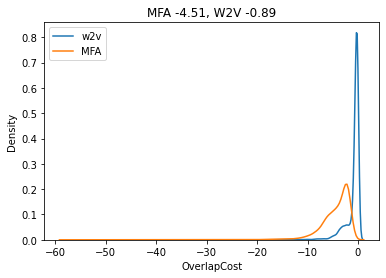

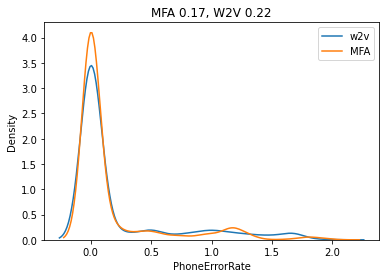

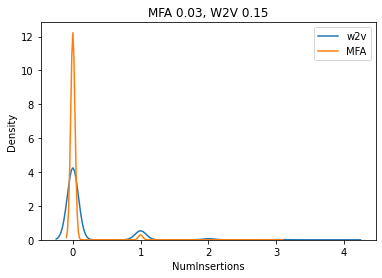

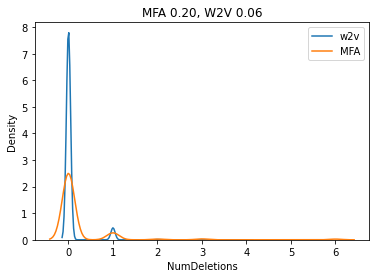

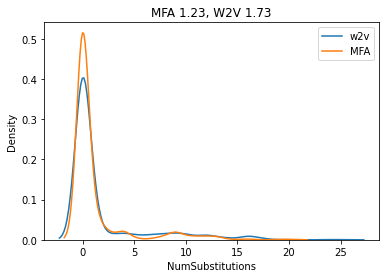

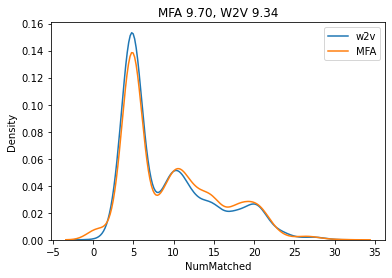

In [487]:
plt.figure()
sns.kdeplot(data=metricdf_xvec, x='OverlapCost', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='OverlapCost', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['OverlapCost']):.2f}, W2V {np.mean(metricdf_xvec['OverlapCost']):.2f}")
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='PhoneErrorRate', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='PhoneErrorRate', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['PhoneErrorRate']):.2f}, W2V {np.mean(metricdf_xvec['PhoneErrorRate']):.2f}")
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumInsertions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumInsertions', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumInsertions']):.2f}, W2V {np.mean(metricdf_xvec['NumInsertions']):.2f}")
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumDeletions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumDeletions', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumDeletions']):.2f}, W2V {np.mean(metricdf_xvec['NumDeletions']):.2f}")
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumSubstitutions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumSubstitutions', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumSubstitutions']):.2f}, W2V {np.mean(metricdf_xvec['NumSubstitutions']):.2f}")
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumMatched', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumMatched', label='MFA')
plt.title(f"MFA {np.mean(metricdf_mfa['NumMatched']):.2f}, W2V {np.mean(metricdf_xvec['NumMatched']):.2f}")
plt.legend()


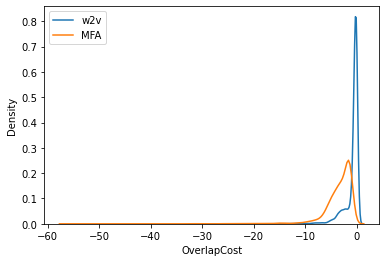

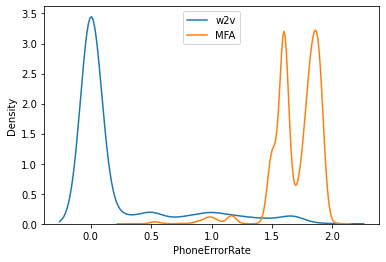

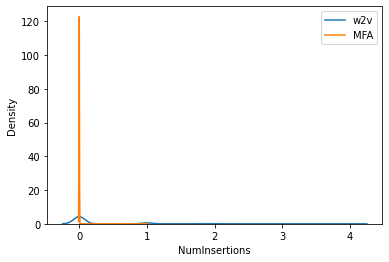

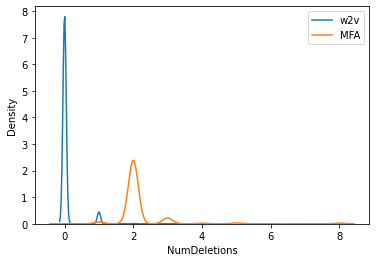

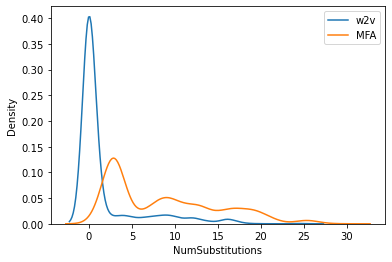

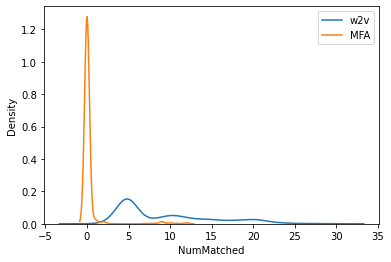

In [417]:
plt.figure()
sns.kdeplot(data=metricdf_xvec, x='OverlapCost', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='OverlapCost', label='MFA')
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='PhoneErrorRate', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='PhoneErrorRate', label='MFA')
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumInsertions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumInsertions', label='MFA')
plt.legend()


plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumDeletions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumDeletions', label='MFA')
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumSubstitutions', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumSubstitutions', label='MFA')
plt.legend()

plt.figure()
sns.kdeplot(data=metricdf_xvec, x='NumMatched', label='w2v')
sns.kdeplot(data=metricdf_mfa, x='NumMatched', label='MFA')
plt.legend()


In [231]:
gt_dfs['AA']['Duration'] = gt_dfs['AA']['end_time'] - gt_dfs['AA']['start_time']

In [ ]:
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    plt.subplot(6, 7, ii+1)
    duration = gt_dfs[phone]['end_time'] - gt_dfs[phone]['start_time']
    plt.hist(duration, bins=100, density=True)    
    plt.xlim([0, 10])
    plt.grid()
    plt.title('%s Duration GT' % phone, fontweight='bold')
plt.savefig('./saved_figures/phone_durations_manual.png')

In [ ]:
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['duration_est_xvector'].values, bins=100)
    plt.xlim([0, 10])
    plt.grid()
    plt.title('%s Duration xVec' % phone, fontweight='bold')
plt.show()

----------------------------------------------------------------------------------------------------------------------
Durations


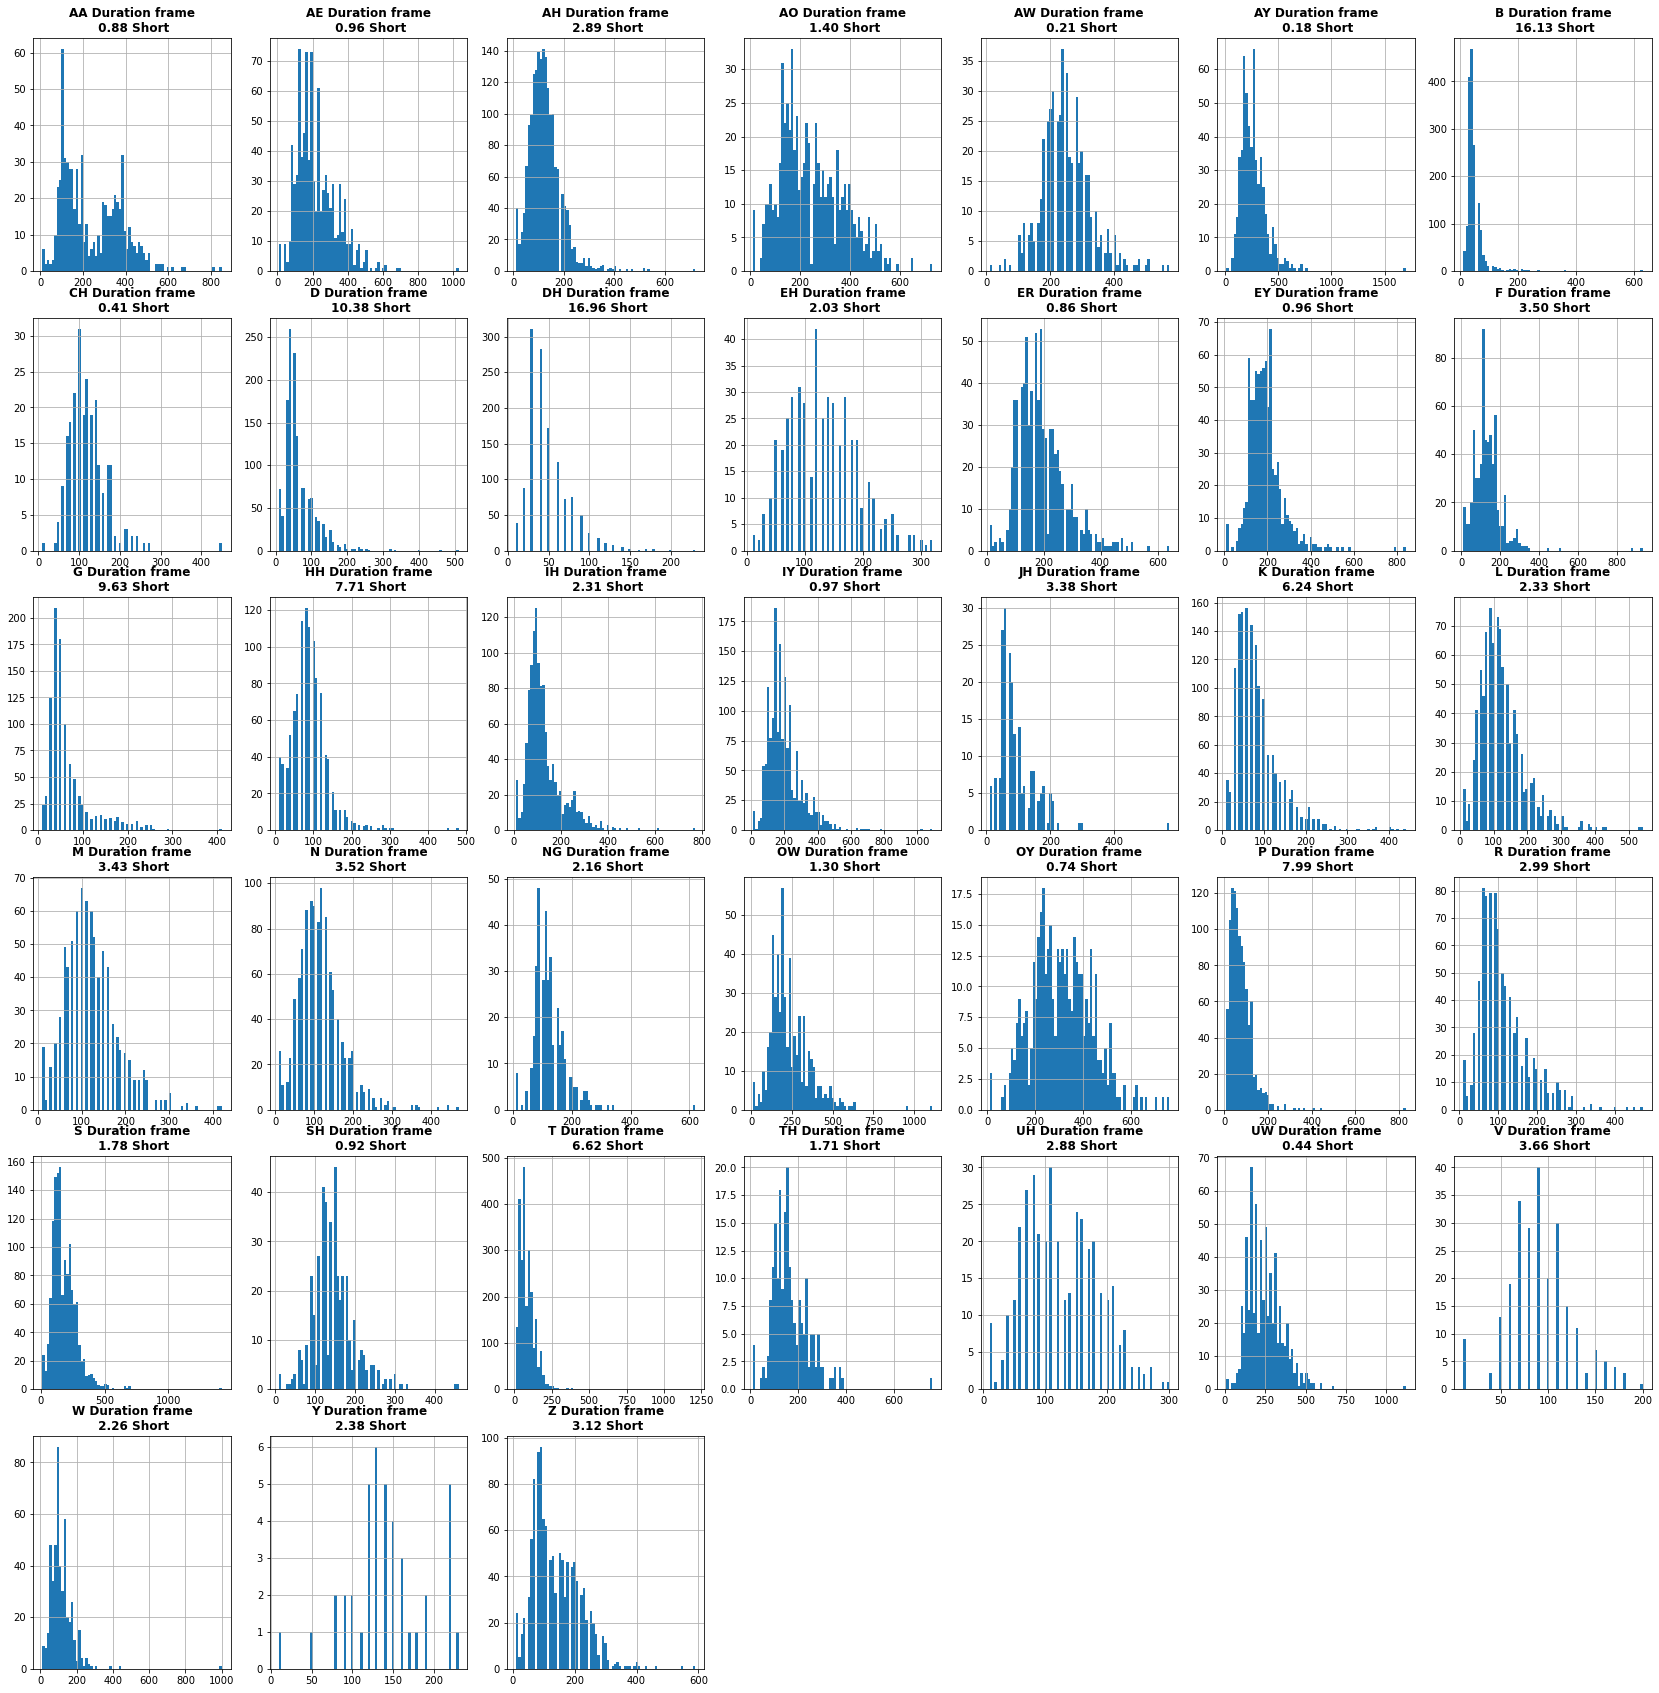

----------------------------------------------------------------------------------------------------------------------
Onset Error


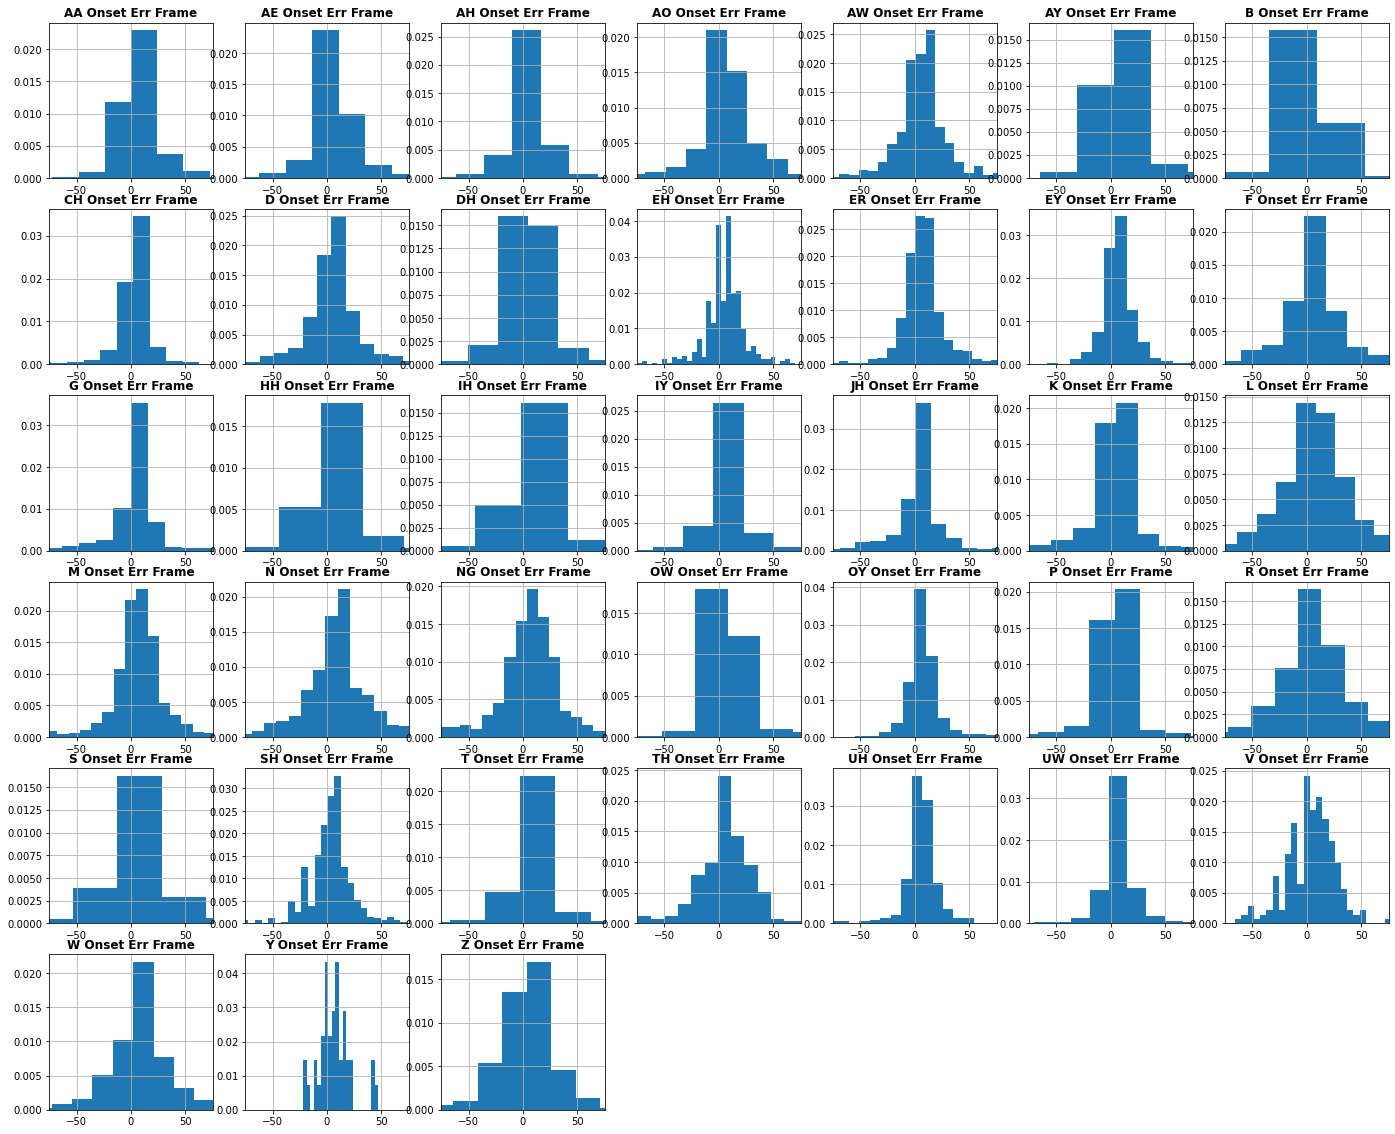

----------------------------------------------------------------------------------------------------------------------
Offset Error


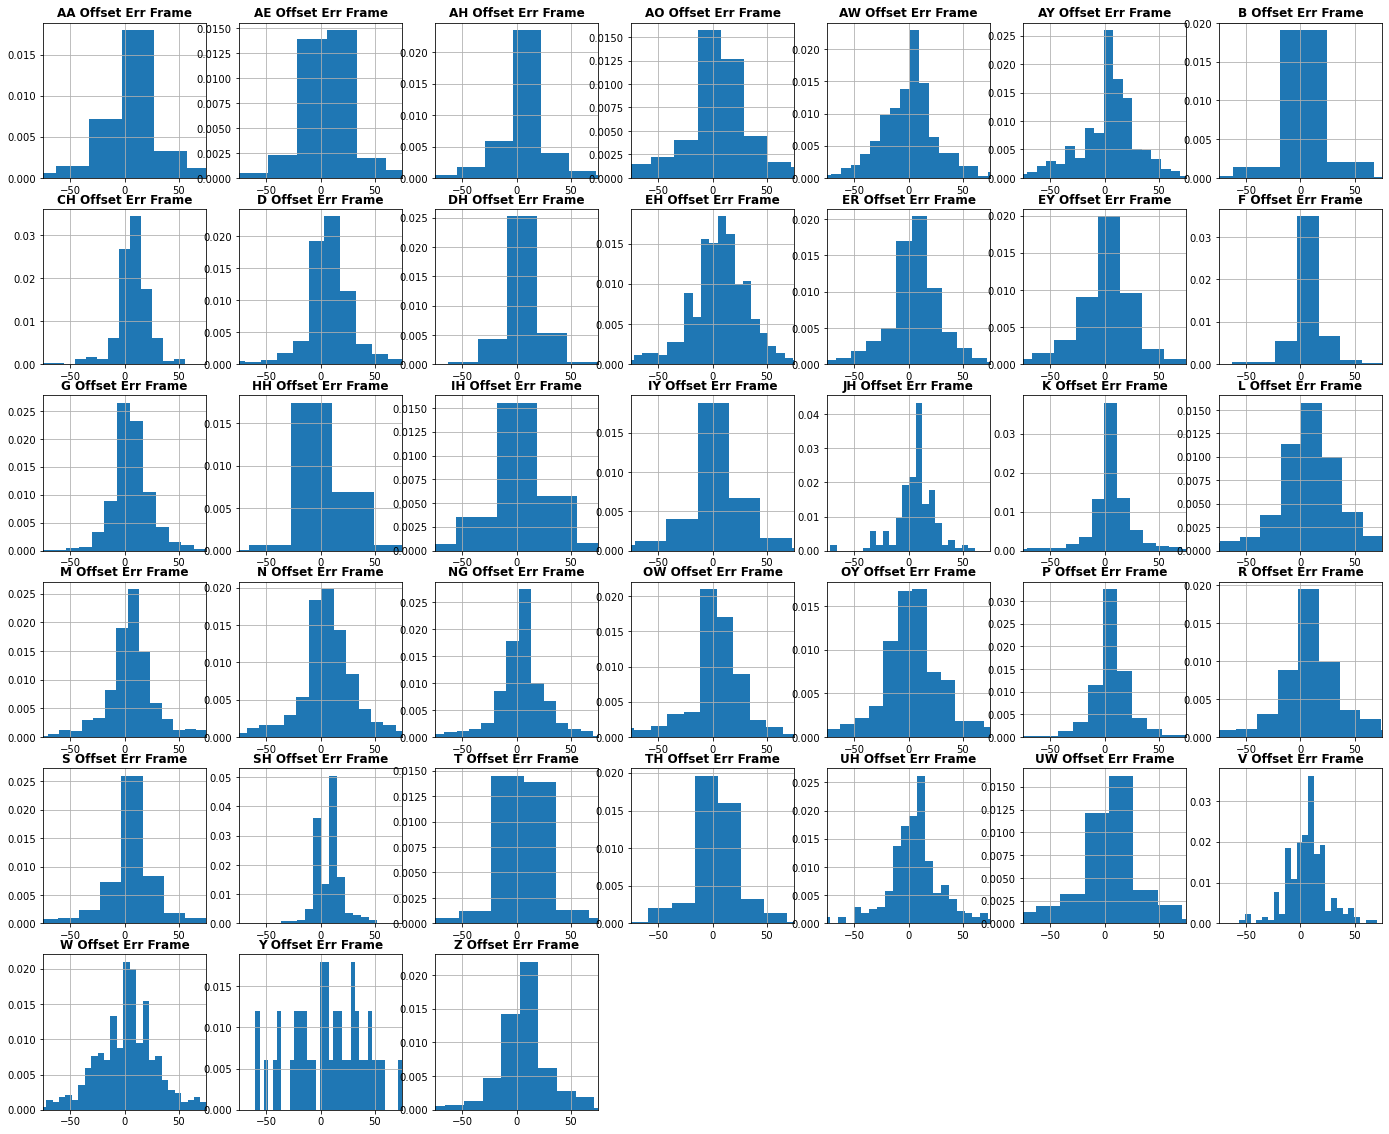

In [326]:
print('----------------------------------------------------------------------------------------------------------------------')
plt.figure(figsize=(29, 30))
print('Durations')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est'].values
    plt.hist(durations, bins=75)
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration frame\n %.2f Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_frame.png')
plt.show()

plt.figure(figsize=(24, 20))
print('----------------------------------------------------------------------------------------------------------------------')
print('Onset Error')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_frame'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err Frame' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_frame.png')
plt.show()

plt.figure(figsize=(24, 20))
print('----------------------------------------------------------------------------------------------------------------------')
print('Offset Error')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_frame'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err Frame' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_frame.png')
plt.show()


----------------------------------------------------------------------------------------------------------------------
Duration


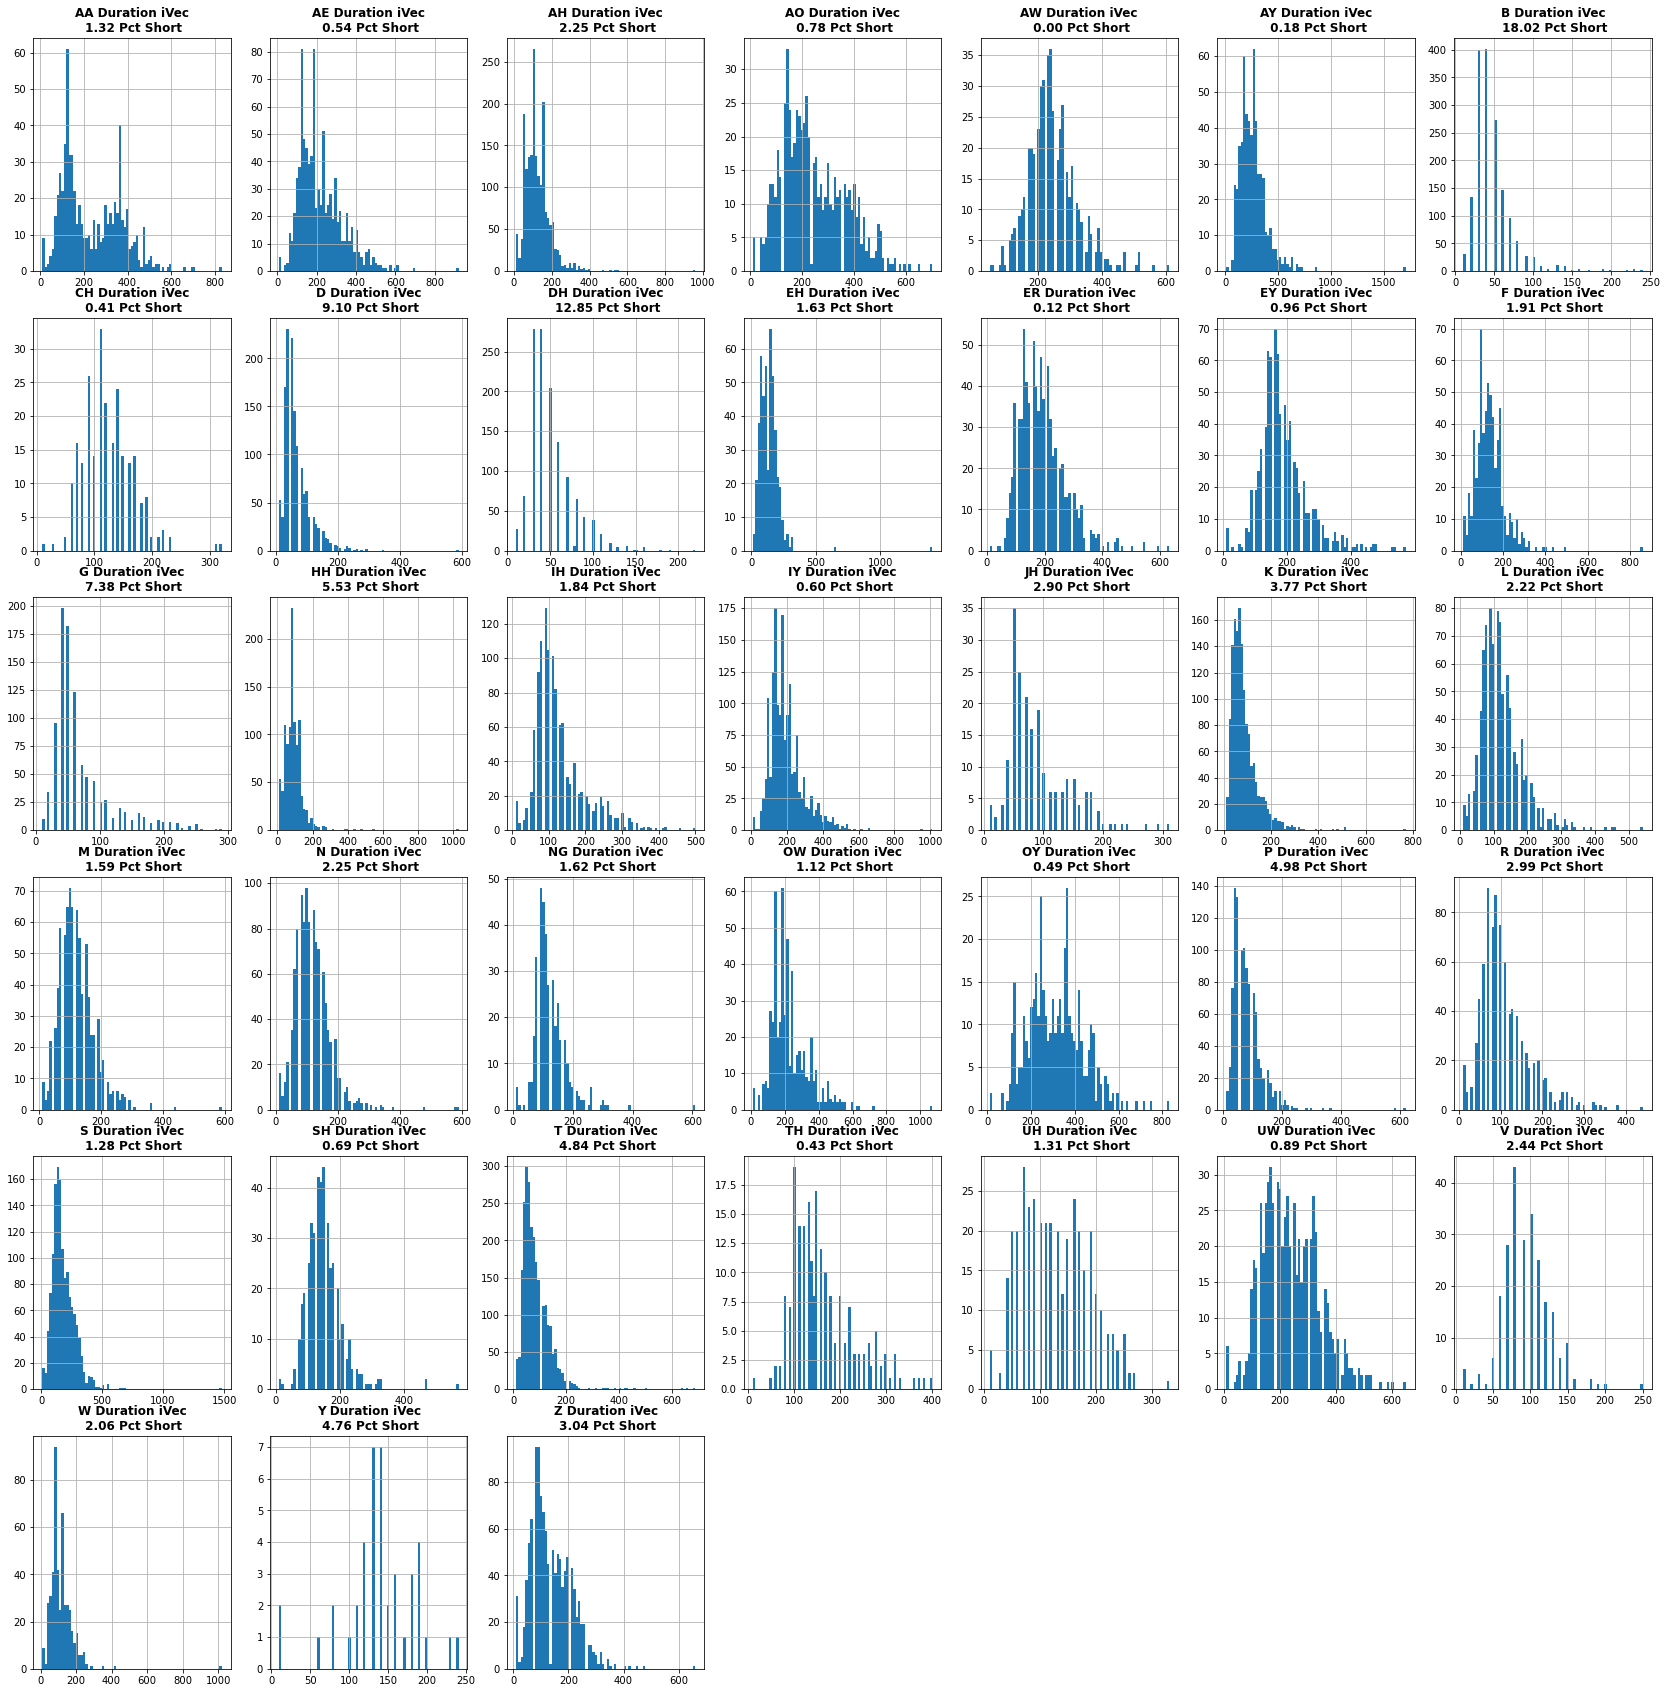

----------------------------------------------------------------------------------------------------------------------
Onset Error


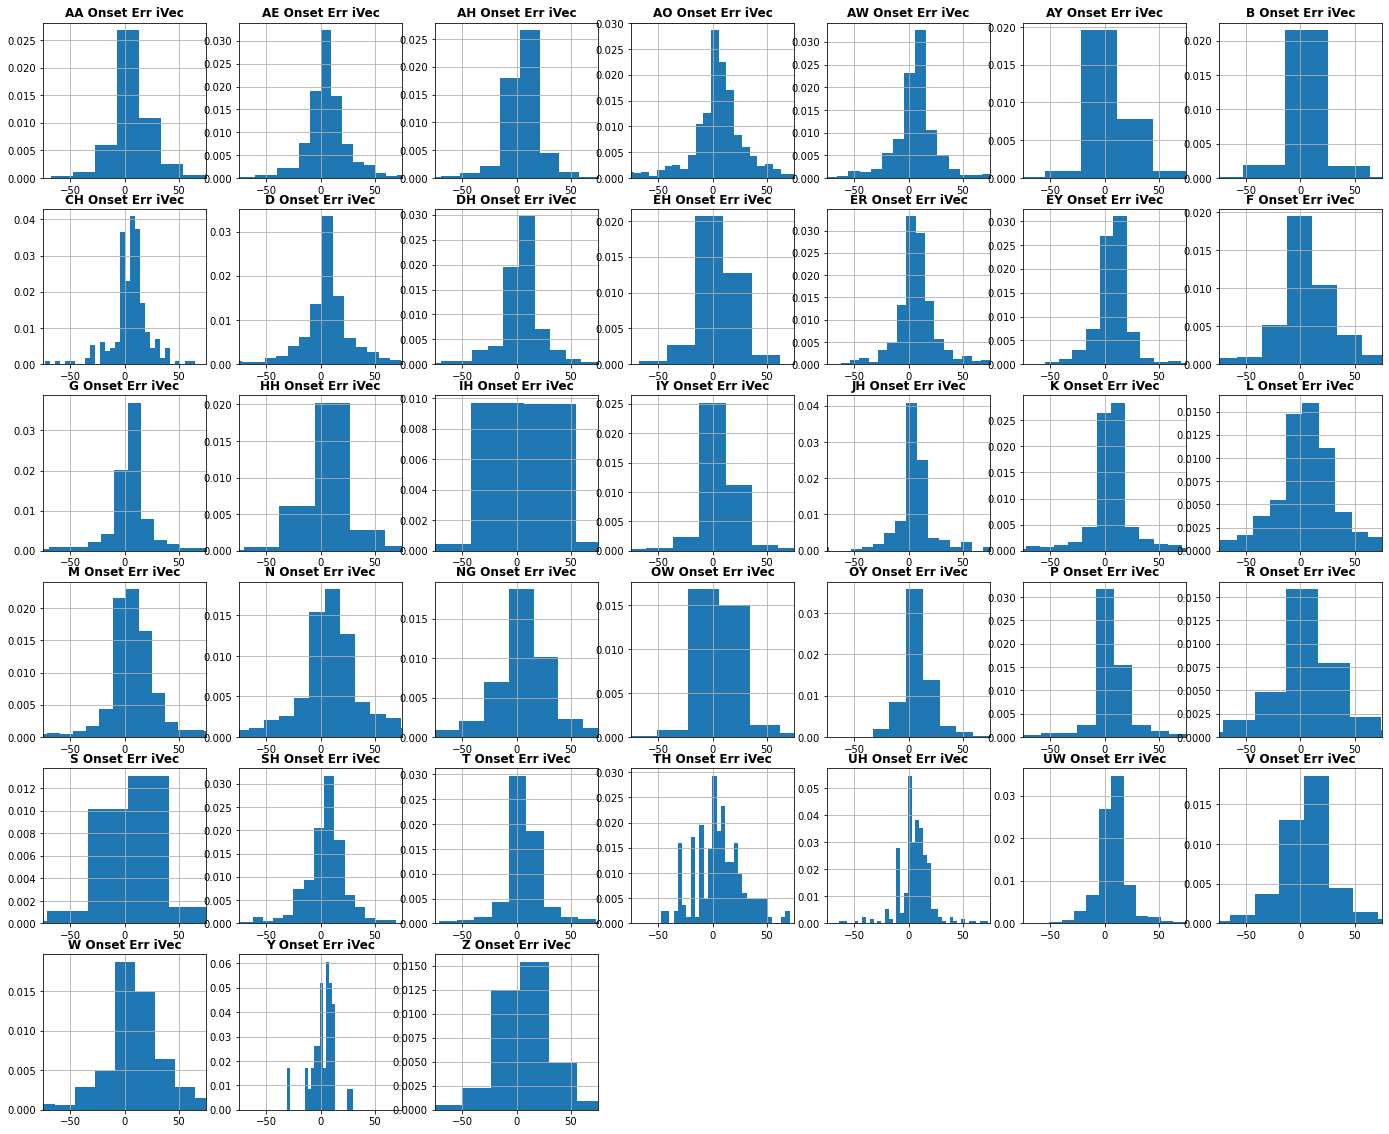

----------------------------------------------------------------------------------------------------------------------
Offset Error


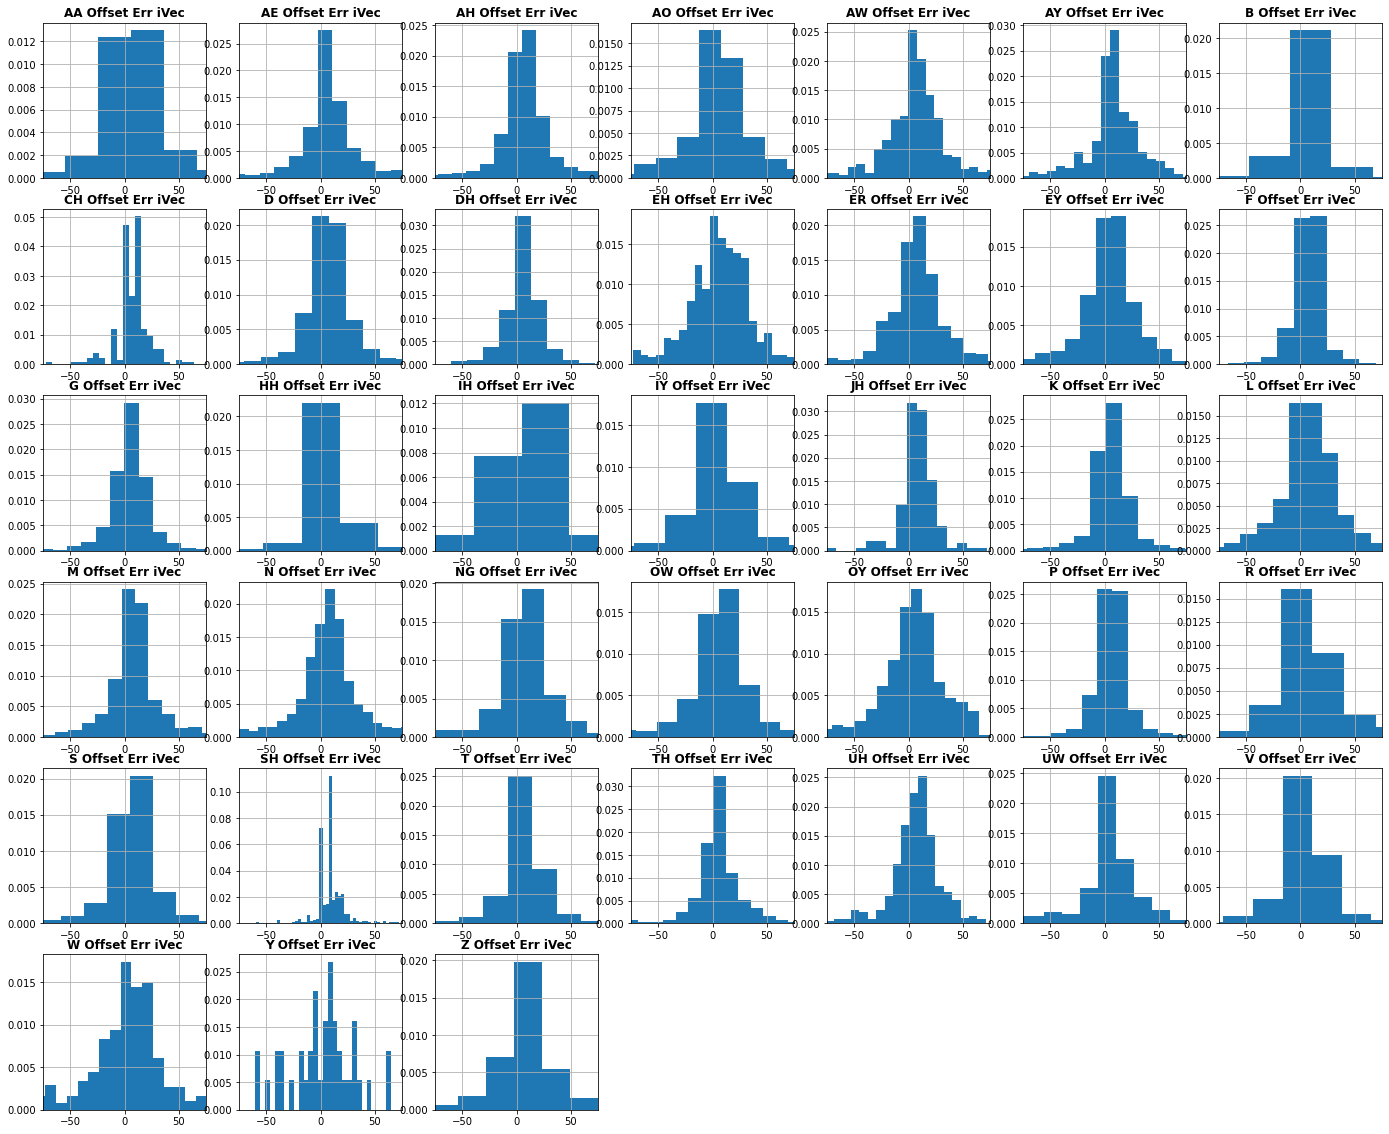

In [325]:
print('----------------------------------------------------------------------------------------------------------------------')
print('Duration')
plt.figure(figsize=(29, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est_ivector'].values
    plt.hist(durations, bins=75)
    # plt.xlim([0, 80])
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration iVec\n %.2f Pct Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_ivec.png')
plt.show()
print('----------------------------------------------------------------------------------------------------------------------')
print('Onset Error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_ivector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err iVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_ivec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset Error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_ivector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err iVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_ivec.png')
plt.show()


----------------------------------------------------------------------------------------------------------------------
duration


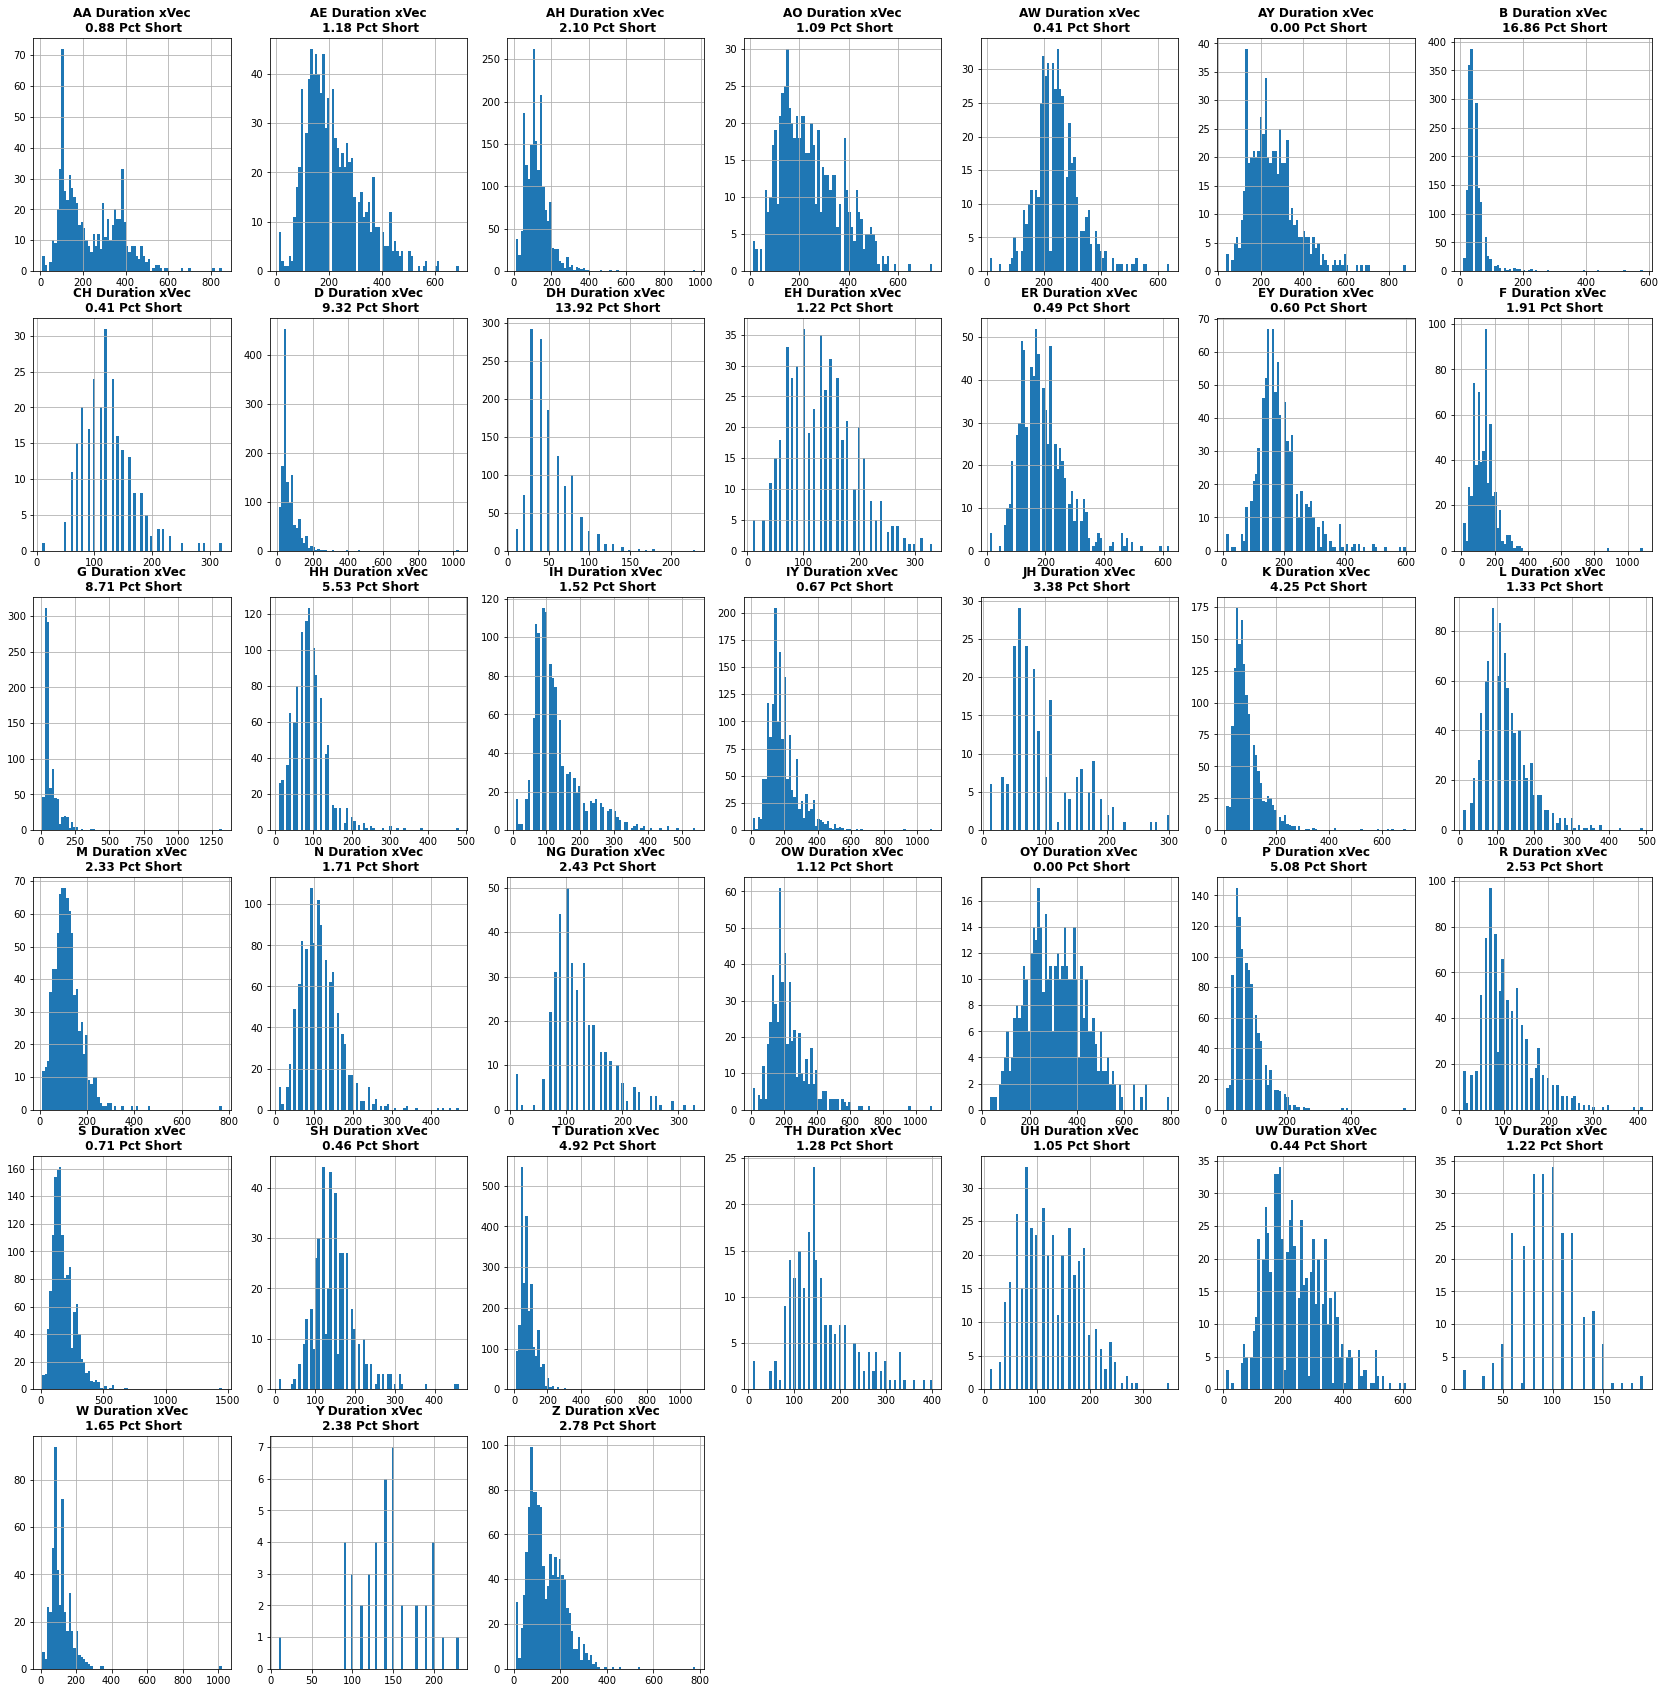

----------------------------------------------------------------------------------------------------------------------
Onset error


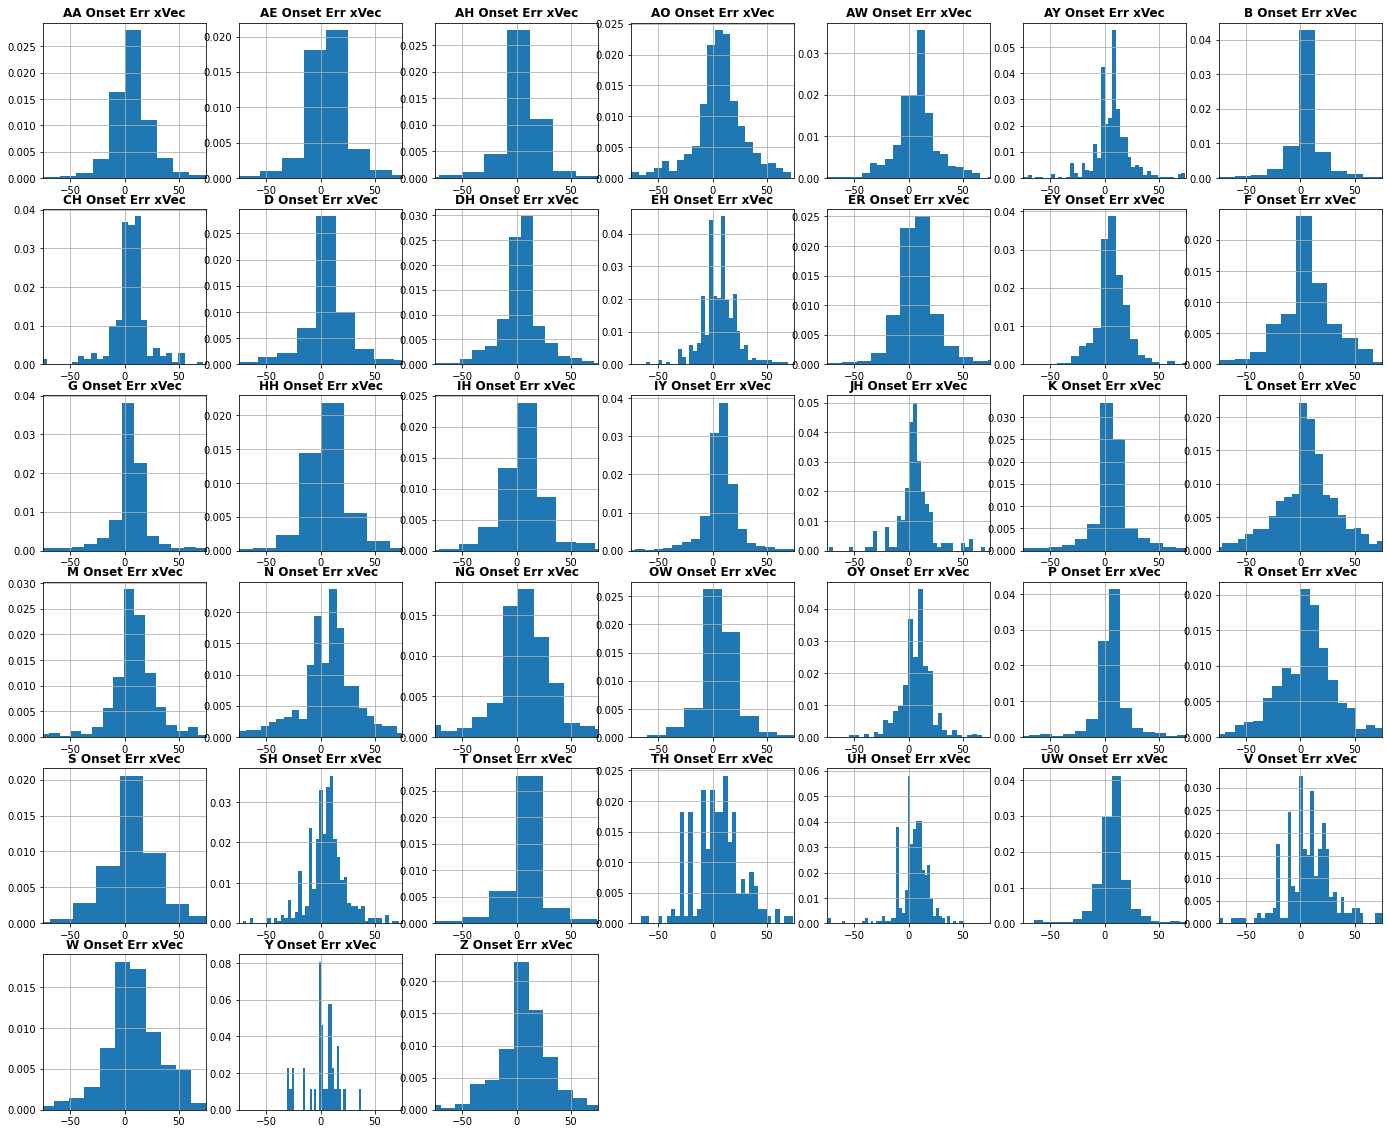

----------------------------------------------------------------------------------------------------------------------
Offset error


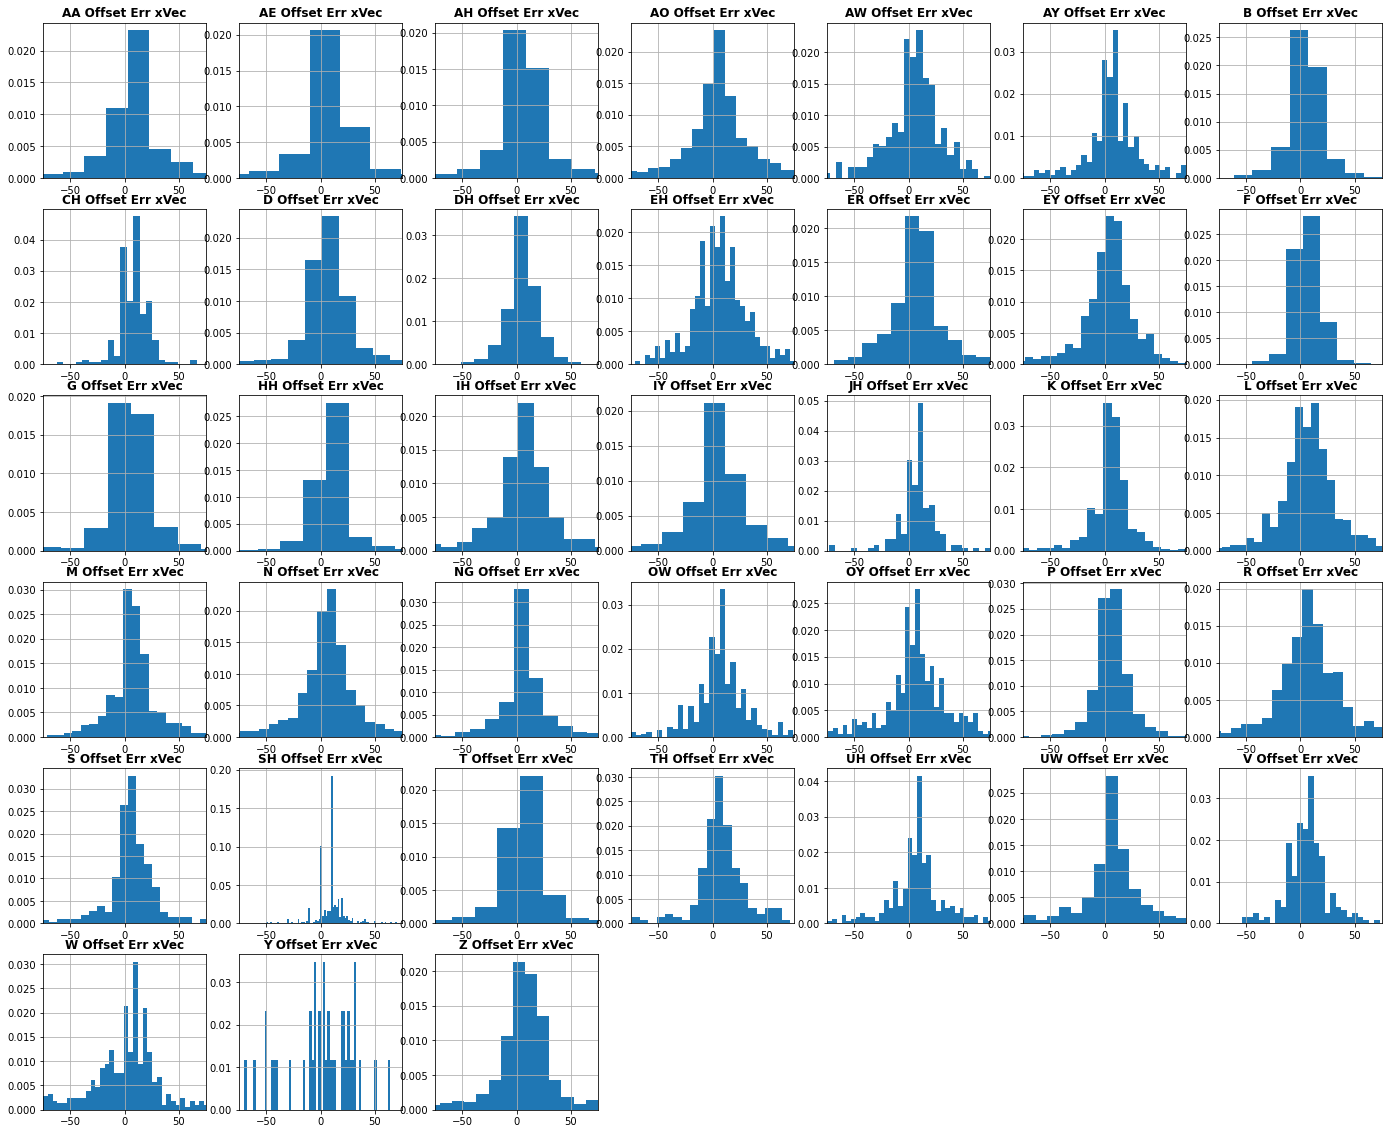

In [324]:
print('----------------------------------------------------------------------------------------------------------------------')
print('duration')
plt.figure(figsize=(29, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est_xvector'].values
    plt.hist(durations, bins=75)
    # plt.xlim([0, 80])
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration xVec\n %.2f Pct Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Onset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_xvector'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err xVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_xvector'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err xVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_xvec.png')
plt.show()

----------------------------------------------------------------------------------------------------------------------
duration


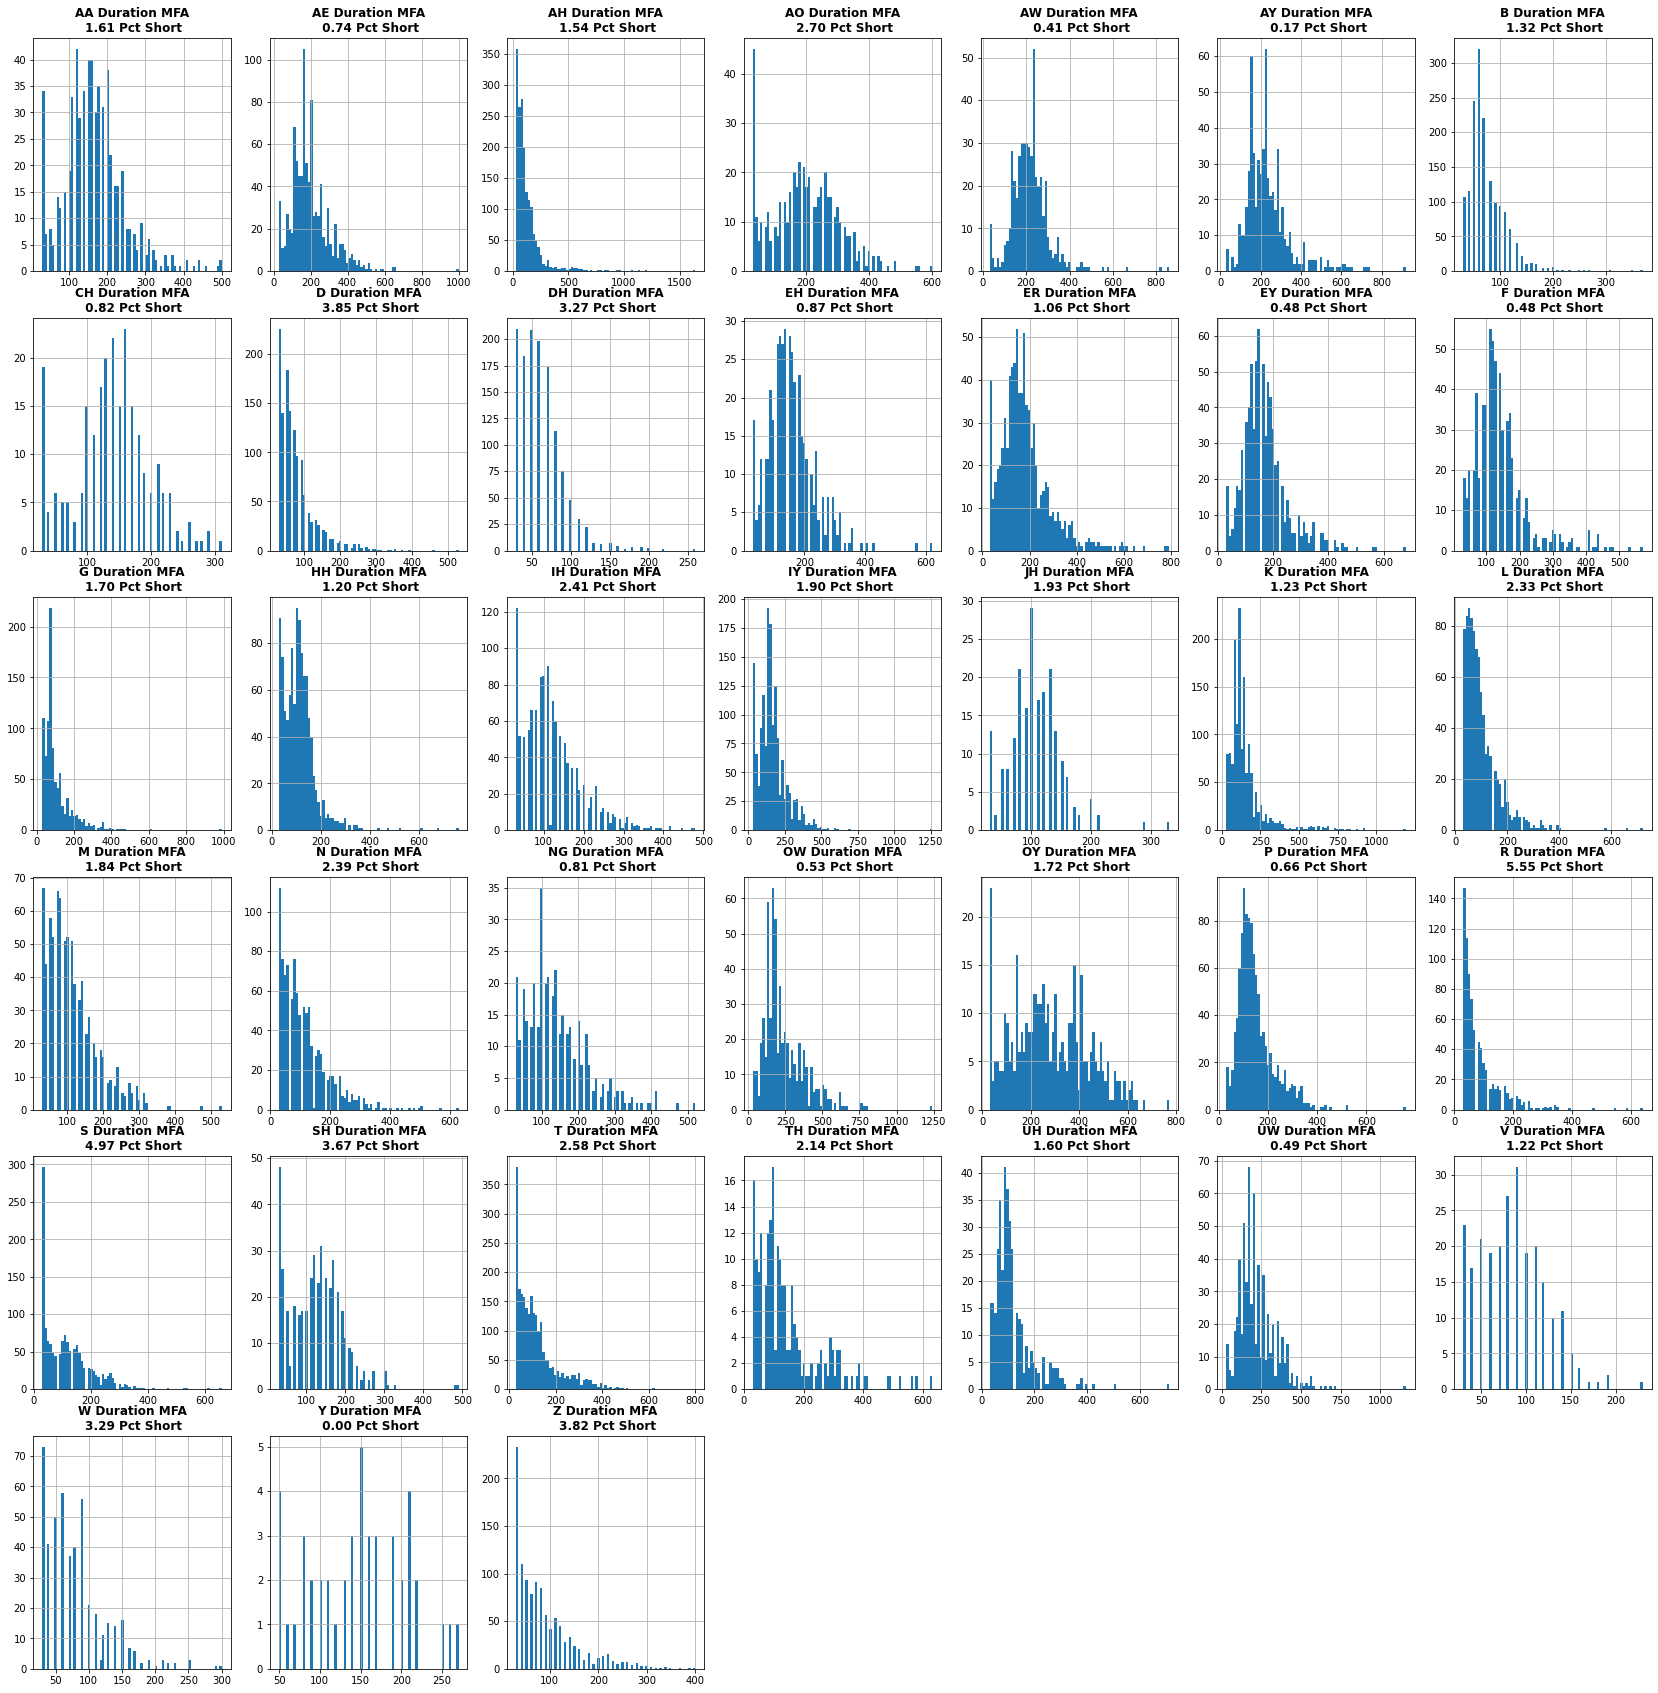

----------------------------------------------------------------------------------------------------------------------
Onset error


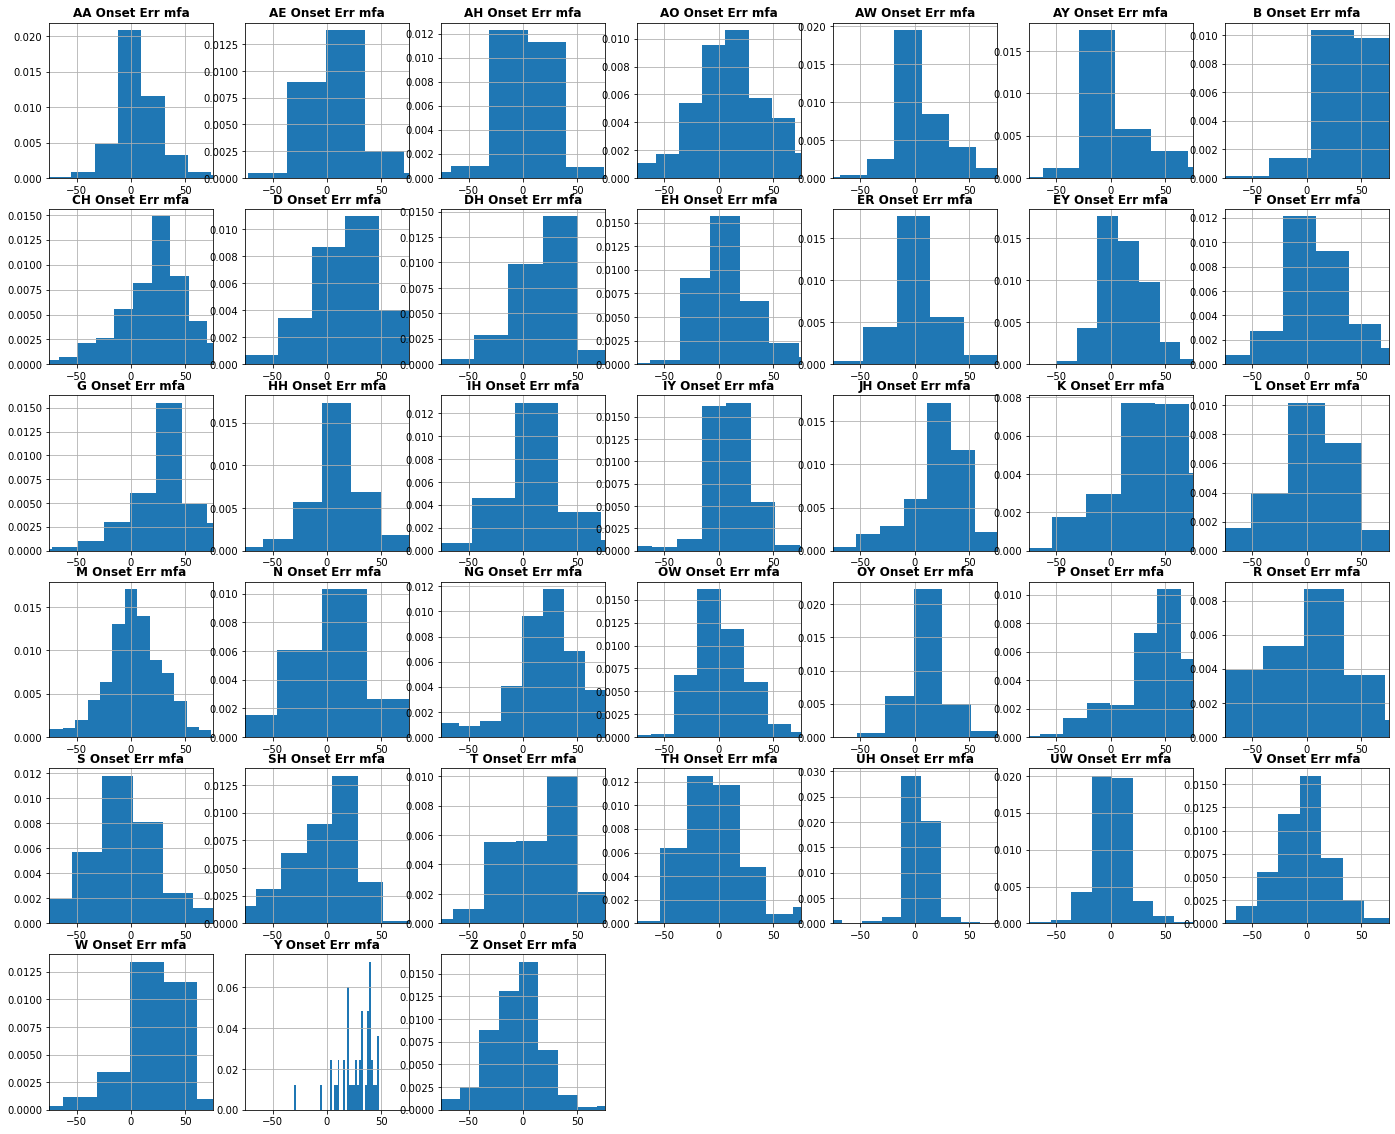

----------------------------------------------------------------------------------------------------------------------
Offset error


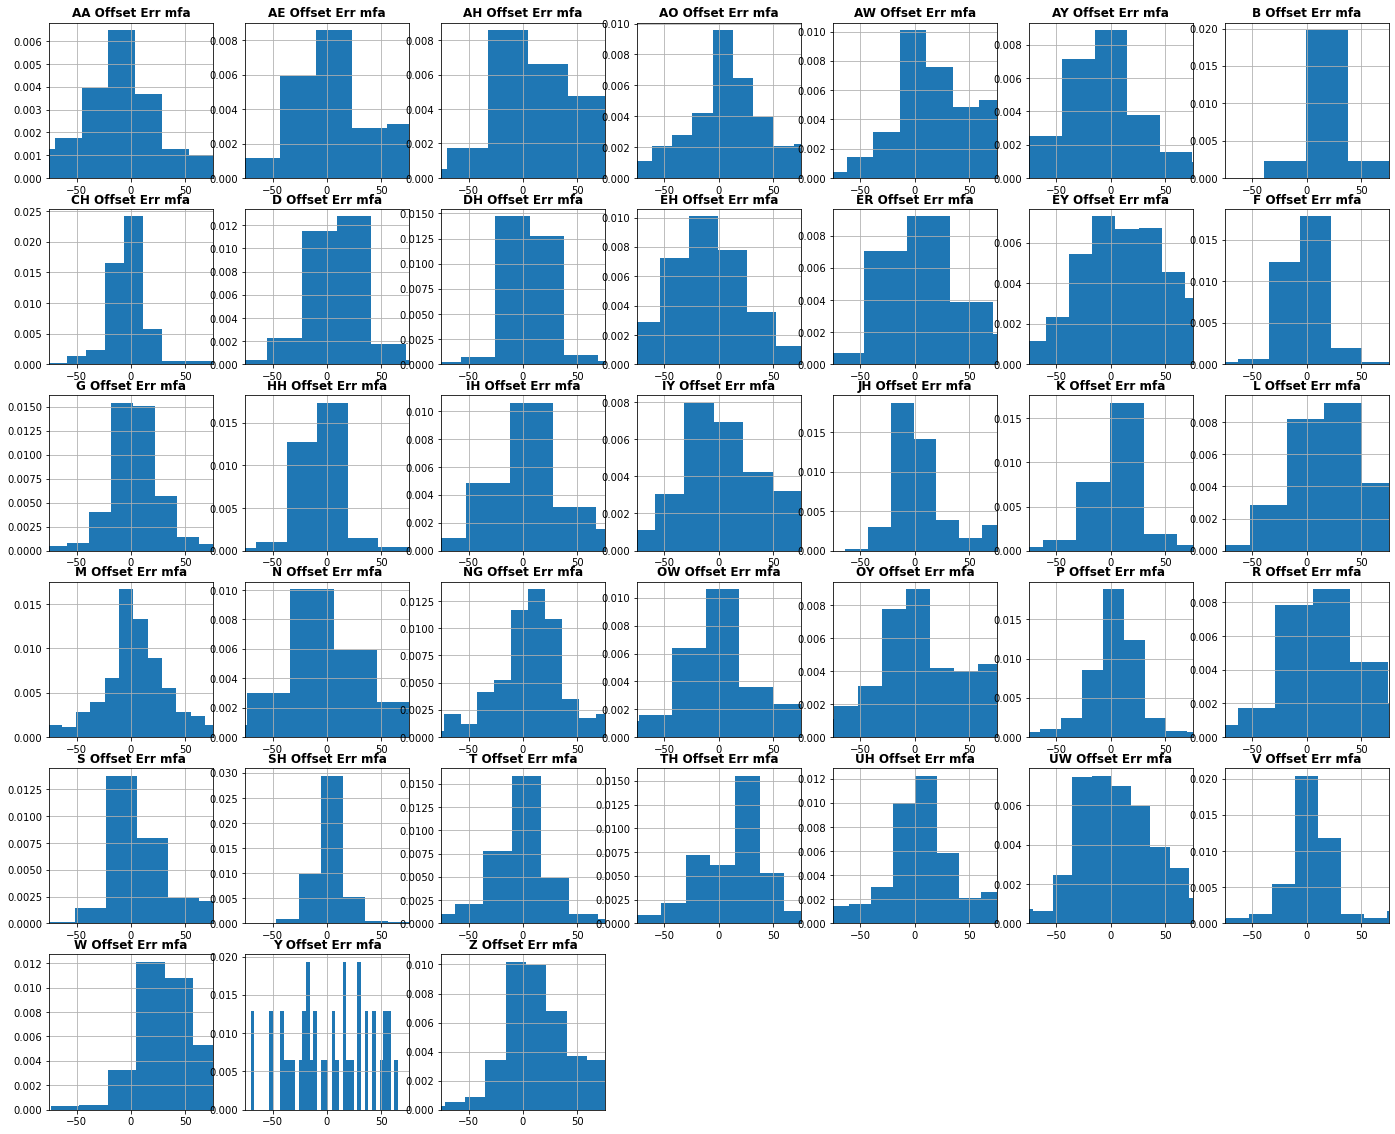

In [323]:
print('----------------------------------------------------------------------------------------------------------------------')
print('duration')
plt.figure(figsize=(29, 30))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['mfa']
    plt.subplot(6, 7, ii+1)
    durations = _df['duration_est_mfa'].values
    plt.hist(durations, bins=75)
    # plt.xlim([0, 80])
    pct_short = 100*sum((durations<30))/len(durations)

    plt.grid()
    plt.title('%s Duration MFA\n %.2f Pct Short' % (phone, pct_short), fontweight='bold')
plt.savefig('./saved_figures/phone_durations_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Onset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['mfa']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_mfa'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err mfa' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['mfa']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_mfa'].values, bins=75, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err mfa' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_mfa .png')
plt.show()

In [233]:
plt.figure(figsize=(20, 24))

dct = {}
phones = []

onset_error_mean_frame = []
onset_error_std_frame = []

onset_error_mean_ivec = []
onset_error_std_ivec = []

onset_error_mean_xvec = []
onset_error_std_xvec = []

onset_error_mean_mfa = []
onset_error_std_mfa = []


offset_error_mean_frame = []
offset_error_std_frame = []

offset_error_mean_xvec = []
offset_error_std_xvec = []

offset_error_mean_ivec = []
offset_error_std_ivec = []

offset_error_mean_mfa = []
offset_error_std_mfa = []

for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    
    df_dct = phone_dfs[phone]
    fdf = df_dct['frame']
    idf = df_dct['ivector']
    xdf = df_dct['xvector']
    mdf = df_dct['mfa']
    
    if len(fdf['onset_err_frame'].values)==1:
        onset_error_mean_frame.append(np.nanmean(np.abs(fdf['onset_err_frame'].values)))
        onset_error_std_frame.append(0)
        offset_error_mean_frame.append(np.nanmean(np.abs(fdf['offset_err_frame'].values)))
        offset_error_std_frame.append(0)
    else:
        onset_error_mean_frame.append(np.nanmean(np.abs(fdf['onset_err_frame'].values)))
        onset_error_std_frame.append(np.nanstd(np.abs(fdf['onset_err_frame'].values)))
        offset_error_mean_frame.append(np.nanmean(np.abs(fdf['offset_err_frame'].values)))
        offset_error_std_frame.append(np.nanstd(np.abs(fdf['offset_err_frame'].values)))
        
    if len(idf['onset_err_ivector'].values)==1:
        onset_error_mean_ivec.append(np.nanmean(np.abs(idf['onset_err_ivector'].values)))
        onset_error_std_ivec.append(0)
        offset_error_mean_ivec.append(np.nanmean(np.abs(idf['offset_err_ivector'].values)))
        offset_error_std_ivec.append(0)       
    else:
        onset_error_mean_ivec.append(np.nanmean(np.abs(idf['onset_err_ivector'].values)))
        onset_error_std_ivec.append(np.nanstd(np.abs(idf['onset_err_ivector'].values)))
        offset_error_mean_ivec.append(np.nanmean(np.abs(idf['offset_err_ivector'].values)))
        offset_error_std_ivec.append(np.nanstd(np.abs(idf['offset_err_ivector'].values)))
    
    if len(xdf['offset_err_xvector'].values)==1:
        onset_error_mean_xvec.append(np.nanmean(np.abs(xdf['onset_err_xvector'].values)))
        onset_error_std_xvec.append(0)
        offset_error_mean_xvec.append(np.nanmean(xdf['offset_err_xvector'].values))
        offset_error_std_xvec.append(0)
    else:
        onset_error_mean_xvec.append(np.nanmean(np.abs(xdf['onset_err_xvector'].values)))
        onset_error_std_xvec.append(np.nanstd(np.abs(xdf['onset_err_xvector'].values)))
        offset_error_mean_xvec.append(np.nanmean(np.abs(xdf['offset_err_xvector'].values)))
        offset_error_std_xvec.append(np.nanstd(np.abs(xdf['offset_err_xvector'].values)))
        
        
    if len(mdf['offset_err_mfa'].values)==1:
        onset_error_mean_mfa.append(np.nanmean(np.abs(mdf['onset_err_mfa'].values)))
        onset_error_std_mfa.append(0)
        offset_error_mean_mfa.append(np.nanmean(mdf['offset_err_mfa'].values))
        offset_error_std_mfa.append(0)
    else:
        onset_error_mean_mfa.append(np.nanmean(np.abs(mdf['onset_err_mfa'].values)))
        onset_error_std_mfa.append(np.nanstd(np.abs(mdf['onset_err_mfa'].values)))
        offset_error_mean_mfa.append(np.nanmean(np.abs(mdf['offset_err_mfa'].values)))
        offset_error_std_mfa.append(np.nanstd(np.abs(mdf['offset_err_mfa'].values)))

    phones.append(phone)

    
datadf = pd.DataFrame.from_dict({'phone':phones, 'onset_err_frame':onset_error_mean_frame, 'onset_err_std_frame':onset_error_std_frame, 
                        'offset_err_frame': offset_error_mean_frame, 'offset_err_std_frame': offset_error_std_frame,
                        'onset_err_ivec': onset_error_mean_ivec, 'onset_err_std_ivec': onset_error_std_ivec, 
                        'offset_err_ivec': offset_error_mean_ivec, 'offset_err_std_ivec': offset_error_std_ivec, 
                        'onset_err_xvec': onset_error_mean_xvec, 'onset_err_std_xvec': onset_error_std_xvec, 
                        'offset_err_xvec': offset_error_mean_xvec, 'offset_err_std_xvec': offset_error_std_xvec, 
                        'onset_err_mfa': onset_error_mean_mfa, 'onset_err_std_mfa': onset_error_std_mfa, 
                        'offset_err_mfa': offset_error_mean_mfa, 'offset_err_std_mfa': offset_error_std_mfa}, orient='columns')

<Figure size 1440x1728 with 0 Axes>

In [234]:
import seaborn as sns
print('------------------------------------------------------------')
print('Onset Error(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_frame'].values), np.nanmean(datadf['onset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['onset_err_ivec'].values),  np.nanmean(datadf['onset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_xvec'].values), np.nanmean(datadf['onset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_mfa'].values), np.nanmean(datadf['onset_err_std_mfa'].values)))

print('------------------------------------------------------------')

print('Offset errors(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_frame'].values),  np.nanmean(datadf['offset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['offset_err_ivec'].values),  np.nanmean(datadf['offset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_xvec'].values),  np.nanmean(datadf['offset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_mfa'].values),  np.nanmean(datadf['offset_err_std_mfa'].values)))

------------------------------------------------------------
Onset Error(ms)
FT	 19.33, Std (37.09)
Ivec	 18.70, Std (35.61)
Xvec	 18.41, Std (31.53)
MFA	 47.31, Std (95.13)
------------------------------------------------------------
Offset errors(ms)
FT	 22.97, Std (38.62)
Ivec	 22.20, Std (36.62)
Xvec	 21.92, Std (35.10)
MFA	 54.30, Std (98.97)


In [236]:
import seaborn as sns
print('------------------------------------------------------------')
print('Onset Error(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_frame'].values), np.nanmean(datadf['onset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['onset_err_ivec'].values),  np.nanmean(datadf['onset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_xvec'].values), np.nanmean(datadf['onset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_mfa'].values), np.nanmean(datadf['onset_err_std_mfa'].values)))

print('------------------------------------------------------------')

print('Offset errors(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_frame'].values),  np.nanmean(datadf['offset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['offset_err_ivec'].values),  np.nanmean(datadf['offset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_xvec'].values),  np.nanmean(datadf['offset_err_std_xvec'].values)))
print('MFA\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_mfa'].values),  np.nanmean(datadf['offset_err_std_mfa'].values)))

------------------------------------------------------------
Onset Error(ms)
FT	 19.33, Std (37.09)
Ivec	 18.70, Std (35.61)
Xvec	 18.41, Std (31.53)
MFA	 47.31, Std (95.13)
------------------------------------------------------------
Offset errors(ms)
FT	 22.97, Std (38.62)
Ivec	 22.20, Std (36.62)
Xvec	 21.92, Std (35.10)
MFA	 54.30, Std (98.97)


In [ ]:
plt.figure(figsize=(28, 30))

for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    plt.subplot(6, 7, ii+1)
    plt.hist(phonedurations[phone], bins=80, density=True)
    plt.xlim([0, 50])
    plt.grid()
    pct_short = 100*sum(np.array(phonedurations[phone])<30)/len(phonedurations[phone])
    plt.title(f"{phone} Duration xVec\n {pct_short:.4f}% Short", fontweight='bold')
plt.show()

# two alignment accuracy cases:
# How well does the aligner work when the sequence comes from the manual labeler?
# How well does the aligner work when the sequence comes from the g2p?

#Three PLLR cases:
#1. PLLRs generated from manual alignments
#2. PLLRS from forced forced alignments with manual phoneme sequences
#3. PLLRs from forced alignments (with g2p)

In [ ]:
for phone in phones:
    print('-----------------------------')
    print('Phone: \t %s' % phone)
    print()

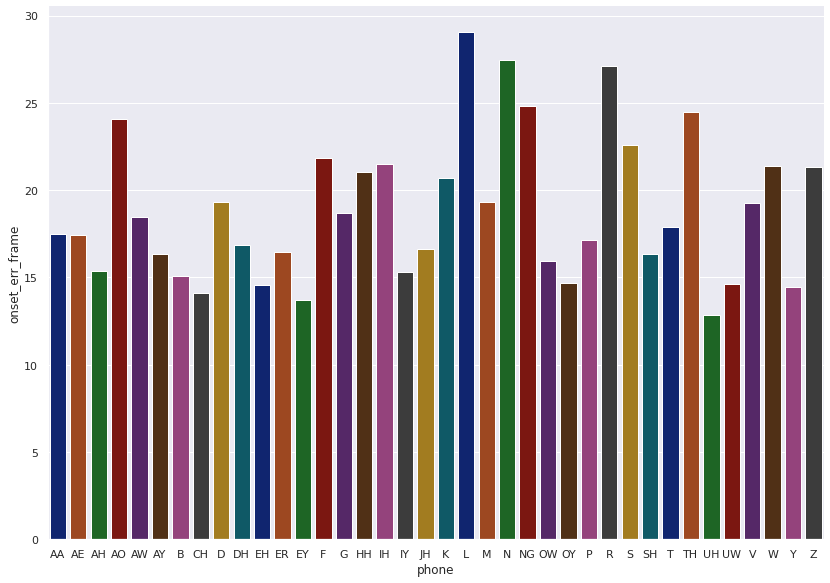

In [39]:
sns.catplot(data=datadf, kind='bar', x='phone', y='onset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

(array([4., 7., 8., 4., 3., 5., 2., 2., 2., 1.]), array([12.84420289, 14.46739048, 16.09057807, 17.71376566, 19.33695325,
       20.96014084, 22.58332843, 24.20651602, 25.82970361, 27.4528912 ,
       29.07607879]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

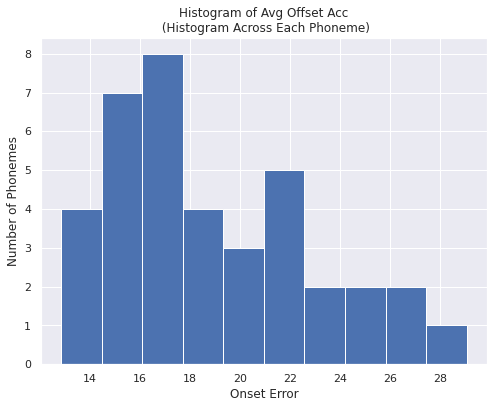

In [63]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_frame']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([ 2.,  3., 10.,  3.,  7.,  1.,  4.,  1.,  4.,  3.]), array([11.01294032, 12.63184582, 14.25075131, 15.86965681, 17.4885623 ,
       19.1074678 , 20.72637329, 22.34527879, 23.96418428, 25.58308977,
       27.20199527]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

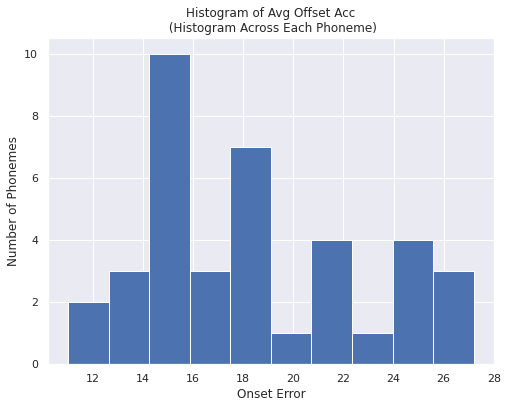

In [64]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_ivec']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([2., 6., 7., 5., 3., 5., 4., 0., 4., 2.]), array([11.36525213, 12.95279979, 14.54034746, 16.12789513, 17.7154428 ,
       19.30299047, 20.89053813, 22.4780858 , 24.06563347, 25.65318114,
       27.24072881]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

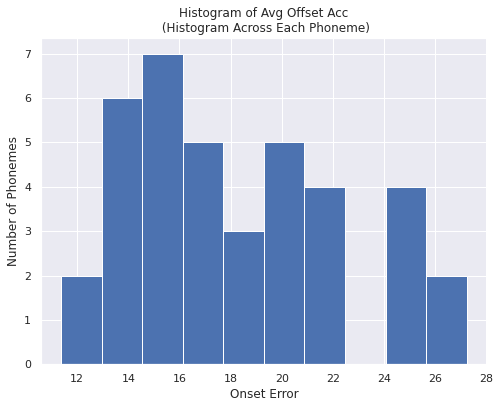

In [65]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_xvec']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([4., 7., 8., 4., 3., 5., 2., 2., 2., 1.]), array([12.84420289, 14.46739048, 16.09057807, 17.71376566, 19.33695325,
       20.96014084, 22.58332843, 24.20651602, 25.82970361, 27.4528912 ,
       29.07607879]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

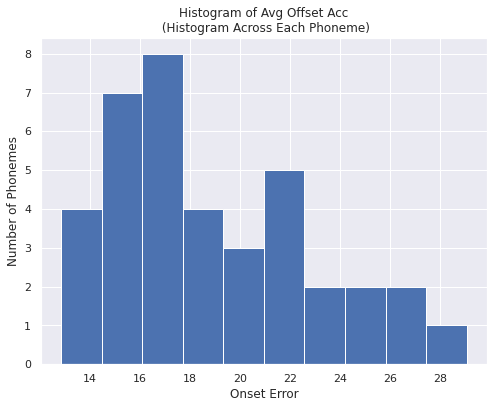

In [66]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_frame']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([1., 0., 2., 4., 4., 1., 4., 4., 9., 2., 3., 0., 2., 1.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

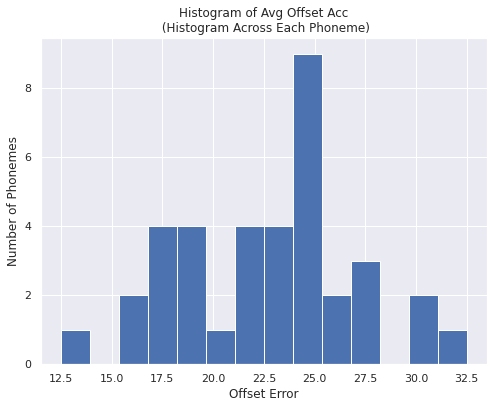

In [81]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_frame'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

(array([2., 2., 2., 2., 1., 3., 6., 4., 2., 7., 3., 2., 0., 1.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

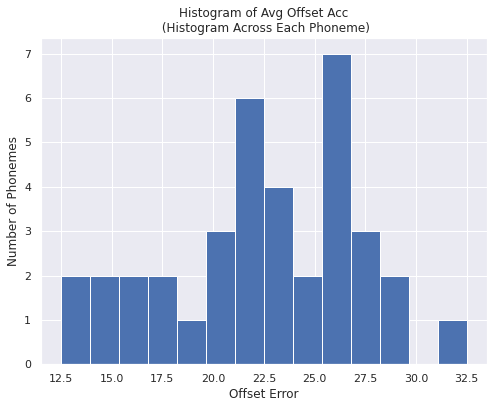

In [79]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_ivec'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

(array([3., 0., 2., 1., 3., 1., 6., 5., 6., 6., 1., 1., 1., 0.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

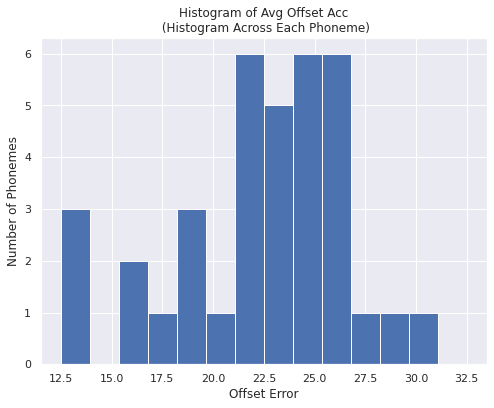

In [80]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_xvec'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

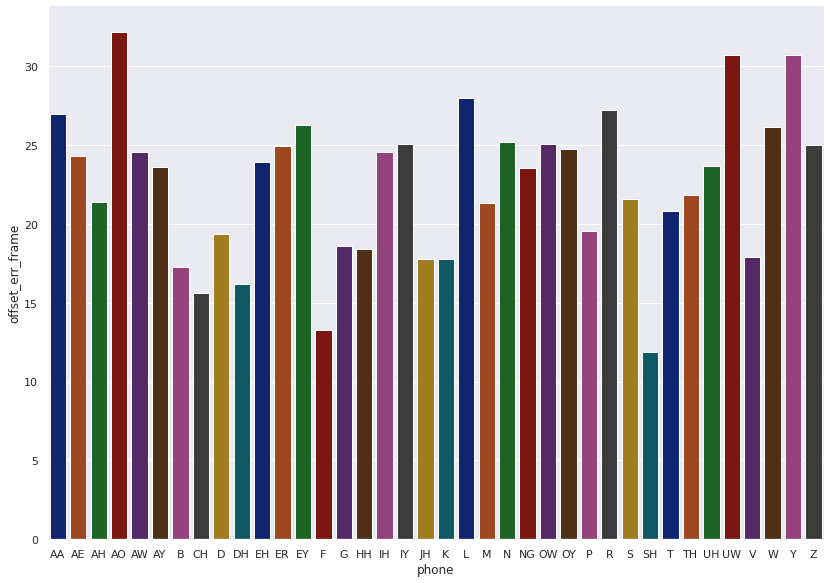

In [38]:
# plt.figure(figsize=(12,36))
# fig, ax = plt.subplots(figsize=(12,36))
# sns.set(rc={'figure.figsize':(12, 36)})
sns.catplot(data=datadf, kind='bar', x='phone', y='offset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

In [ ]:
# plt.figure(figsize=(12,36))
# fig, ax = plt.subplots(figsize=(12,36))
# sns.set(rc={'figure.figsize':(12, 36)})
sns.catplot(data=datadf, kind='bar', x='phone', y='offset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

In [13]:
np.mean(datadf['onset_err_frame'])

5.90656516910839

Start with a dictionary where the keys are all phonemes including silence
Then loop across speakers to calculate the following
Then loop through each phoneme in the textgrid

Average Phoneme Length plotting to find which ones get deleted often
- calculate the length of the phoneme for each case [manual, ivector, xvector, frame]

Onset/offset times
- create a function that compares the alignment accuracy in terms of onset/offset time
- for each phoneme 
- in a dictionary keep two lists for each phoneme: onset_time_errror and ofset_time_error
    
    
    

This thing should be easily parallelizable, you should learn how to parallelize it




In [ ]:
''' extract dictionary (speaker-wise) of the performance information'''

speaker_tgs = {}

for speaker_id in list(satdf.index):
    
    _results = {}
    tg_dct = {}

    tg_dct['Manual'] = manual_tgs_path
    tg_dct['iVec'] = finetuned_tgs_ivec
    tg_dct['xVec'] = finetuned_tgs_xvec
    tg_dct['Frame'] = finetuned_tgs_frame

In [ ]:
for speaker_id_in list(satdf.index):
    manual_tgs_path = [tgpath for tgpath in unmatched_manual_textgrid_files if speaker_id in tgpath]
    finetuned_tgs_ivec = get_all_textgrids_in_directory(results_dir_ivec, )

In [18]:
os.path.join(results_dir_frame, tgpath.split('/')[-2], tgpath.split('/')[-1])

'./results_frame_10epochs/results_sat/'

In [17]:
rslts_df.to_csv('./accuracy_results_ft_and_sat_methods.csv')

In [13]:
print(np.mean(rslts_df['PerfDiffiVec']))
print(np.mean(rslts_df['PerfDiffxVec']))

0.013917636604036807
0.014661981089438305


In [14]:
print(np.mean(rslts_df['iVecSATAccuracy']))
print(np.mean(rslts_df['xVecSATAccuracy']))

0.9184989953136226
0.9192433397990243


(array([1., 0., 0., 1., 0., 0., 1., 1., 0., 2.]),
 array([4.33333333, 4.575     , 4.81666667, 5.05833333, 5.3       ,
        5.54166667, 5.78333333, 6.025     , 6.26666667, 6.50833333,
        6.75      ]),
 <a list of 10 Patch objects>)

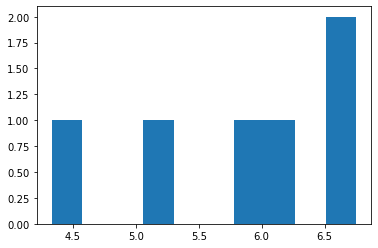

In [27]:
''' Plot histogram of Decliners'''
decliners_ivec = list(rslts_df[rslts_df['PerfDiffiVec']<0].index)
decliners_xvec = list(rslts_df[rslts_df['PerfDiffiVec']<0].index)

agedec_ivec = [int(spk[:2]) + float(spk[2:4])/12 for spk in decliners_ivec]
agedec_xvec = [int(spk[:2]) + float(spk[2:4])/12 for spk in decliners_xvec]
plt.hist(agedec_ivec)
# ydec_iv, xage1   = np.histogram(agedec_ivec)
# ydec_xv, xage2 = np.histogram(agedec_xvec)


# fig, ax = plt.subplots()
# rects1 = ax.bar(xage1[:-1], ydec_iv, width=0.35, label='iVec')
# rects2 = ax.bar(xage2[:-1], ydec_xv, width=0.35, label='xVec')
# ax.set_ylabel('Num Speakers')
# ax.set_title('Age of Speaker')
# ax.set_xticks(xage1, [str(ag) for ag in xage1[:-1]])
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# # rects1 = ax.bar(agedec,  width, label='Men')
# # rects2 = ax.bar(x + width/2, women_means, width, label='Women')


# plt.legend()
# plt.title('Age of Decliners')

Text(0, 0.5, 'Num Speakers')

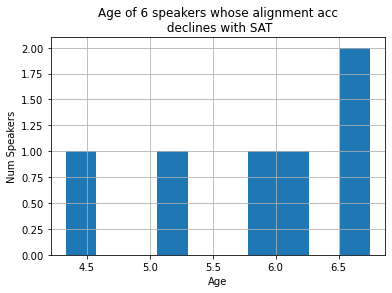

In [28]:
plt.hist(agedec_ivec)
plt.grid()
plt.title('Age of 6 speakers whose alignment acc\n declines with SAT')
plt.xlabel('Age')
plt.ylabel('Num Speakers')

In [17]:
decliners_xvec

['0609_F_AK', '0502_F_KM', '0603_M_LS', '0607_M_CE', '0404_M_TC', '0511_F_IG']

In [ ]:
improvers

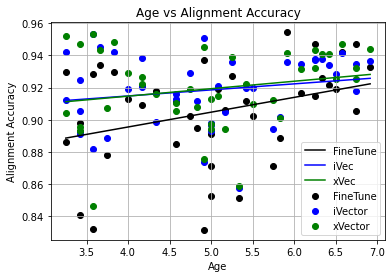

In [21]:
''' Scatter Age vs Alignment Accuracy'''
from sklearn.linear_model import LinearRegression

ages = [int(spk[:2]) + float(spk[2:4])/12 for spk in list(rslts_df.index)]
ages_lm = np.linspace(min(ages), max(ages), 100).reshape(-1, 1)

lmframe = LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['FrameWise_Acc'])
lmivec =  LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['iVecSATAccuracy'])
lmxvec =  LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['xVecSATAccuracy'])
plt.scatter(ages, rslts_df['FrameWise_Acc'], c='k', label='FineTune')
plt.scatter(ages, rslts_df['iVecSATAccuracy'], c='b', label='iVector')
plt.scatter(ages, rslts_df['xVecSATAccuracy'], c='g', label='xVector')


plt.plot(ages_lm, lmframe.predict(ages_lm), 'k', label='FineTune')
plt.plot(ages_lm, lmivec.predict(ages_lm),'b', label='iVec')
plt.plot(ages_lm, lmxvec.predict(ages_lm), 'g', label='xVec')


plt.legend()
plt.title('Age vs Alignment Accuracy')
plt.xlabel('Age')
plt.ylabel('Alignment Accuracy')
plt.grid()

In [22]:
improvers_ivec = list(rslts_df[rslts_df['PerfDiffiVec']>.03].index)
improvers_xvec =  list(rslts_df[rslts_df['PerfDiffxVec']>.03].index)
print(improvers_ivec)
print(improvers_xvec)

['0500_M_QA', '0305_F_AN', '0411_M_LM', '0407_M_SJ', '0307_F_IC']
['0500_M_QA', '0305_F_AN', '0411_M_LM', '0305_F_MB', '0509_F_ES']


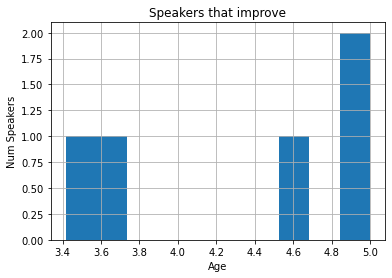

In [33]:
improvers=list(rslts_df[rslts_df['PerfDiffiVec']>.03].index)
plt.hist([int(imp[:2])+float(imp[2:4])/12 for imp in improvers])
plt.title('Speakers that improve')
plt.ylabel('Num Speakers')
plt.xlabel('Age')

plt.grid()

In [25]:
np.mean(rslts_df['SAT_Accuracy'])

0.9184989953136228

In [26]:
print(np.mean(rslts_df['PerfDiff']))
print(np.max(rslts_df['PerfDiff']))

0.013917636604036807
0.04988344988344984


Text(0, 0.5, 'Number of Speakers')

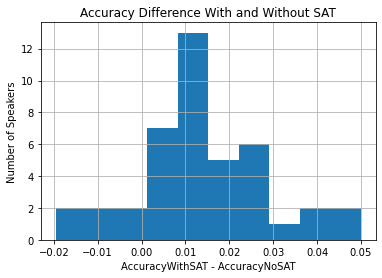

In [28]:
plt.figure()
plt.hist(rslts_df['PerfDiff'].values)
# plt.xlim([-.1, .25])
plt.grid()
plt.title('Accuracy Difference With and Without SAT')
plt.xlabel('AccuracyWithSAT - AccuracyNoSAT')
plt.ylabel('Number of Speakers')

In [ ]:
perf_dif = rslts_df['PerfDiff'].values[rslts_df['PerfDiff']<0]
np.mean(perf_dif)
np.max(perf_dif)

In [ ]:
strange_idxs = np.argwhere(np.array(perfdif)<0).ravel()
strange_speakers = [perf_diff[sidxs] for sidxs in strange_idxs]

In [ ]:
strange_speakers

In [ ]:
asdf = np.random.rand(1000)
xmin = -2.5
xmax = 7
plt.hist(asdf, bins=100)

In [62]:
''' 
create a 5 part dataset
'''

def piecewise_posterior(npoints=10000, n_components=5, priors=None, xmin=0, xmax=1):
    x = np.random.rand(npoints) 
    x = x  * (xmax - xmin) + xmin
    
    
    y = np.zeros_like(x) 
    posterior = np.zeros_like(x)
    
    
    